# Summer Project: Pulse Synthesizer

This Jupyter Notebook will contain all the work carried out during the 5-week duration of the project, with markdown cells used to describe and explain what is carried out wherever necessary.

### Project Overview / UROP Description:

The basement of Huxley is the birthplace of some of the world’s shortest laser pulses. Such pulses have an array of different uses, ranging from scientific to medical and security needs. A major challenge is characterizing these ultrashort pulses, in order to be able to reproduce the pulse that is to be used further. The project involves using computational methods to characterize the superposition of arbitrary ultrashort laser pulses that are described by Gaussian wavepackets.

In the laboratory, a laser pulse generator passes beams through three different channels that produce distinct wavelength wavepackets. Although this project is carried out bearing in mind the current situation with the three channels in place, the flexibility in the style of coding allows it to be easily changed to accommodate more channels. These wavepackets then superpose to form an arbitrary wavepacket. This wavepacket has a number of different parameters, namely: amplitude, duration, phase, chirp, frequency, lag. The project aims to retrieve these parameters for each pulse in order to be able to reconstruct a given signal.

There exist various methods that can be utilized in order to achieve this. These boil down to different optimization techniques. One of the most oft-used is simulated annealing. Python, the coding language that is being used for the purposes of this project, has switched from this method and uses basin hopping instead, acting in a similar manner as a probabilistic technique used for obtaining the global minimum of functions.

The project also includes coding a genetic algorithm in order to be able to obtain the parameters of these wavepackets by finding the global minimum. Similar to the process that drives biological evolution, the genetic algorithm takes two parents that are selected in random and uses them to reproduce and generate further generation. The process repeats itself for an arbitrary number of generations, a process which causes the population to evolve towards an optimal solution.

By simulating the situation in the lab and by setting the constraints to replicate physical wavepackets produced in the current situation, the project aims at recovering the parameters that can be used to reproduce a number of different signal types which could be of particular significance. To illustrate the case, a shifted saw-tooth function, commonly referred to within the field as “perfect wave”, can be recreated.

As already mentioned, the project will be carried out using Python, mainly on Jupyter notebooks which allow for an interactive style of coding along with easily comprehendible markdowns and comments. The files will be shared amongst the partners via Dropbox and a weekly meeting with the supervisor will ensure the progress and focus remains on track.

The project is described below week by week as we perfomed the tasks agreed with the supervisor during our weekly meetings:

In [2]:
#Here we import whatever will be used throughout the project.

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize as minimize
import numpy.fft as fourier
from scipy.optimize import curve_fit
from scipy.optimize import basinhopping as bsn
from numpy.random import uniform
from numpy.random import random
from numpy.random import rand

### Week 1

### Task 1: 
### Implement a function for the electric field as a function of time (t) of a laser pulse (EM wavepacket) with a Gaussian envelope with the following parameters:

 - Amplitude, in arbitrary units
 - Pulse Duration ($\Delta$t) (FWHM of intensity envelope), in fs
 - Central angular frequency ($\omega_0$), in rad/s
 - Phase ($\phi$), in rad
 - Chirp parameter ($\beta$), in rad/s$^2$
 - Delay/Lag ($\tau$), in fs

We'll start by defining a function that descibes a single wavepacket.

In [3]:
def wave_packet(absolute_time,dt = 10,omega = 1,lag = 20,b =0.1 ,phi = 1,A=1):
    '''
    For a value of absolute time, returns electric field amplitude of the wavepacket
    defined by passed parameters.
    '''
    t = absolute_time - lag
    E = A*np.exp((omega*t + b*t*t + phi)*1j)*np.exp(-(t*t)*2*np.log(2)/(dt*dt))
    return E,np.absolute(E)**2, b*t*t + phi

### Task 2:

### Plot as $f(t)$:

- The real electric field
- The intensity
- The phase of the carrier

/Users/marioskassapis/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Phase')

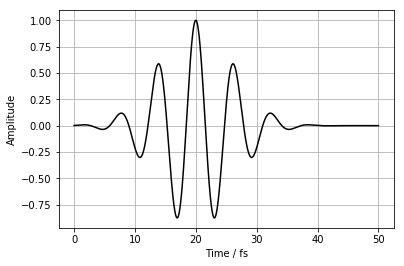

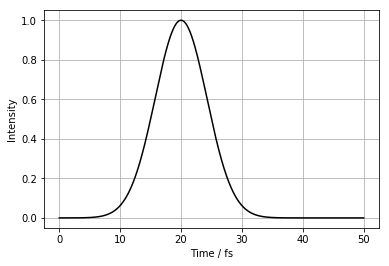

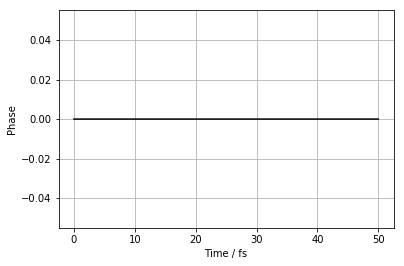

In [3]:
time = np.linspace(0,50,10000)
wp1 = wave_packet(time,dt = 10
                  ,omega = 1,lag = 20
                  ,b =0.0 ,phi = 0)

plt.plot(time,wp1[0], color = "black")
plt.grid()
plt.xlabel("Time / fs")
plt.ylabel("Amplitude")

plt.figure()
plt.plot(time,wp1[1], color = "black")
plt.grid()
plt.xlabel("Time / fs")
plt.ylabel("Intensity")

plt.figure()
plt.plot(time,wp1[2], color = "black")
plt.grid()
plt.xlabel("Time / fs")
plt.ylabel("Phase")

We can now create a superposition of three wavepackets, that produce an arbitrary signal

Text(0, 0.5, 'Phase')

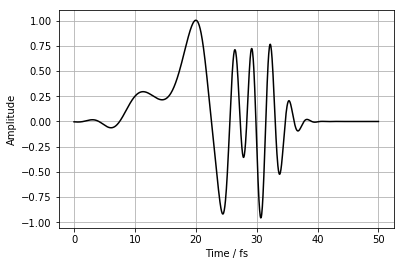

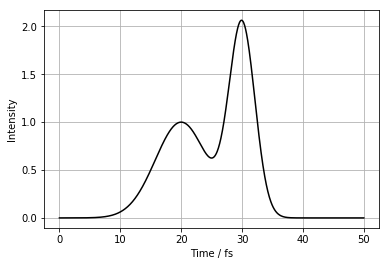

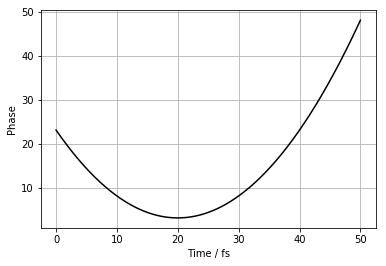

In [4]:
#this is an example for a superposition of three wavepackets

time = np.linspace(0,50,1000)
plt.plot(time,wave_packet(time,dt = 10,omega = 0.5,lag = 20,b =0.05 ,phi = 0)[0]+
         wave_packet(time,dt = 5,omega = 2,lag = 30,b =0.0 ,phi = np.pi/2)[0]+
        wave_packet(time,dt = 5,omega = 0.02,lag = 30,b =0.0 ,phi = np.pi/2)[0], color = "black")
plt.grid()
plt.xlabel("Time / fs")
plt.ylabel("Amplitude")

#Can also plot the intensity superposition

plt.figure()
plt.plot(time,wave_packet(time,dt = 10,omega = 0.5,lag = 20,b =0.05 ,phi = 0)[1]+
         wave_packet(time,dt = 5,omega = 2,lag = 30,b =0.0 ,phi = np.pi/2)[1]+
        wave_packet(time,dt = 5,omega = 0.02,lag = 30,b =0.0 ,phi = np.pi/2)[1], color = "black")
plt.grid()
plt.xlabel("Time / fs")
plt.ylabel("Intensity")

#Can also plot the phase

plt.figure()
plt.plot(time,wave_packet(time,dt = 10,omega = 0.5,lag = 20,b =0.05 ,phi = 0)[2]+
         wave_packet(time,dt = 5,omega = 2,lag = 30,b =0.0 ,phi = np.pi/2)[2]+
        wave_packet(time,dt = 5,omega = 0.02,lag = 30,b =0.0 ,phi = np.pi/2)[2], color = "black")
plt.grid()
plt.xlabel("Time / fs")
plt.ylabel("Phase")

Having written functions for $E$ and $I$ we can now proceed to the next task which is to obtain the frequency spectrum of the wavepackets via Fast Fourier Transform (FFT)

### Task 3:

### FFT code to calculate the spectrum of the pulse $E(\omega)$ and plot as $f(\omega)$ the intensity $I$ together with the spectral phase $\phi$ on the same axes. 

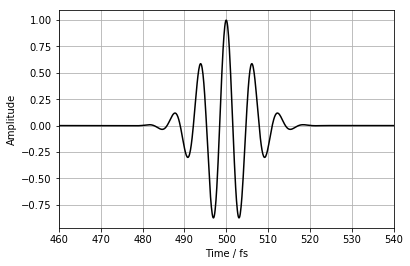

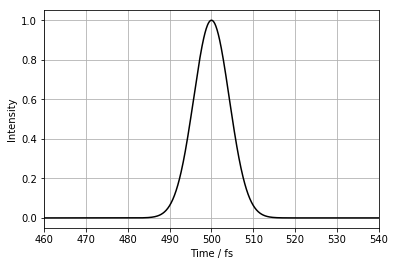

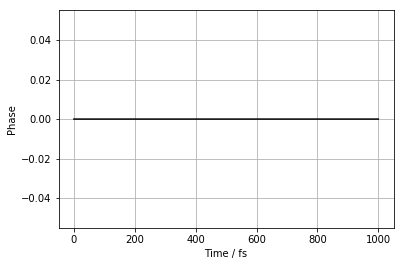

In [5]:
#FFT is applied on raw data rather than a function (means that we need to sample our wavepacket function in specific places)
N = 10000
time_domain = 1000
time = np.linspace(0,time_domain,N)
wv1 = wave_packet(time,dt = 10,omega = 1,lag = 500,b =0.00 ,phi = 0)

#Now we plot the wavepacket, defined from the function wave_packet, at each point sampled from the above linspace.  

plt.plot(time,wv1[0].real,color = "black")
plt.xlabel("Time / fs")
plt.ylabel("Amplitude")
plt.grid()
plt.xlim([460,540])

plt.figure()
plt.plot(time,wv1[1],color = "black")
plt.xlabel("Time / fs")
plt.ylabel("Intensity")
plt.grid()
plt.xlim([460,540])


plt.figure()
plt.plot(time,wv1[2],color = "black")
plt.xlabel("Time / fs")
plt.ylabel("Phase")
plt.grid()

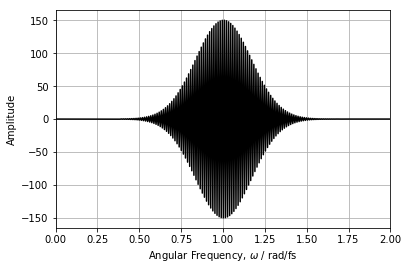

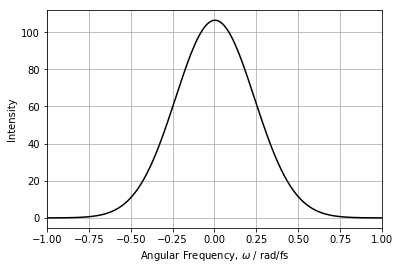

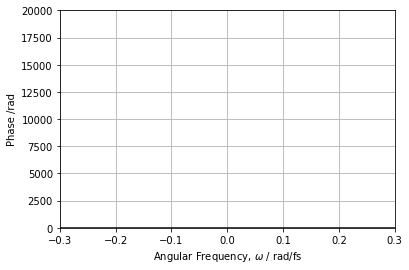

In [6]:
#Now that we have our raw data, wv1, we can Fourier Transform by using FFT applied on this array of raw data. 

wv_omega = fourier.fftshift(fourier.fft(wv1[0]))
omega_p = np.linspace(-N/2,N/2,N)*2*np.pi/time_domain
#plt.plot(omega_p,fourier.fftshift(wv_omega))
plt.plot(omega_p,wv_omega.real, color = 'black')
#plt.axis([0,0.2,-300,320])
plt.xlabel("Angular Frequency, $\omega$ / rad/fs")
plt.ylabel("Amplitude")
plt.grid()
plt.xlim([0,2])

plt.figure()
I_omega = fourier.fftshift(fourier.fft(wv1[1]))
plt.plot(omega_p,(np.abs(I_omega.real)), color = 'black')
#plt.plot(omega_p,np.absolute(wv_omega.real)**2)
#plt.plot(omega_p,I_omega.imag, marker = ".", color = 'black')
#plt.axis([3.1,3.2,-300,320])
plt.xlabel("Angular Frequency, $\omega$ / rad/fs")
plt.ylabel("Intensity")
plt.grid()
plt.xlim([-1,1])

plt.figure()
Phase_omega = fourier.fftshift(fourier.fft(wv1[2]))
plt.plot(omega_p,np.abs(Phase_omega.real), color = 'black')
plt.axis([-0.3,0.3,-10,20000])
plt.xlabel("Angular Frequency, $\omega$ / rad/fs")
plt.ylabel("Phase /rad")
plt.grid()


### Task 4:

### Write an additional function to numerically determine the FWHM of $I(\omega) = \Delta\omega$

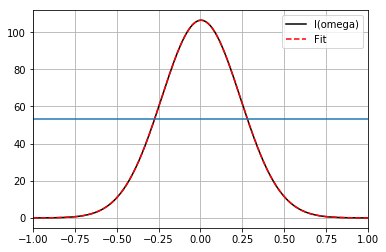

In [7]:
def gauss(t,A,mu, dt):
    tt= t- mu
    return A*np.exp(-4*np.log(2)*(tt*tt)/(dt*dt))

w = np.linspace(-1,1,100)
#omega axis


plt.plot(omega_p,np.abs(I_omega.real), color = 'black', label = "I(omega)")
plt.xlim([-1,1])
#sigma = gauss1[1]
mean = 0
popt,pcov = curve_fit(gauss,  omega_p, np.abs(I_omega.real))
plt.plot(omega_p,gauss(omega_p,*popt),'--',color = "red", label = "Fit")
plt.plot(omega_p,gauss(popt[2]/2+popt[1],*popt)*time**0)
plt.grid()
plt.legend()

We can now check the bandwidth theorem, expecting a product of 0.441

In [8]:

print(popt)
dw  = popt[2]
print((dw*10)/(2*np.pi))

print(gauss(popt[2]/2 + popt[1],*popt))

[1.06436057e+02 3.14190684e-03 5.54590214e-01]
0.8826577400389957
53.218028700405775


We observe above that the product we obtain is double the one we expect. This is corrected further down - the reason being we Fourier Transform the Intensity instead of the Electric Field. 

### Week 2

### Task 1

This This was a continuation of the final task from Week 1, in which we had to find why we fell off by a factor of 2 in the calculation of the FWHM. As explained above, the reason for this discrepancy was the FT being implemented on the intensity rather than the actual electric field.

For this reason, the graphs from Week 1 are re-plotted below in the correct way: 

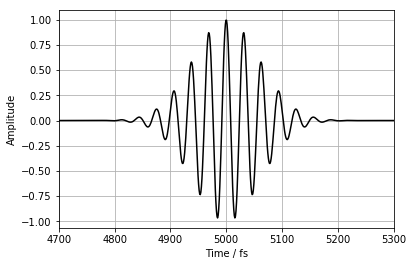

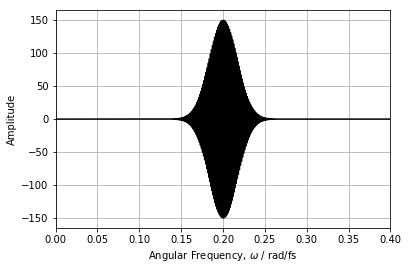

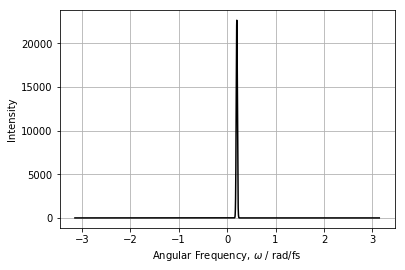

In [9]:
# As before, convert to frequency domain using fftshift. Have to discretise first as we need to take raw data
#FFT is applied on raw data rather than a function (means that we need to sample our wavepacket function in specific places)
N = 10000
time_domain = 10000
time = np.linspace(0,time_domain,N)
wv1 = wave_packet(time,dt = 100,omega = 0.2,lag = 5000,b =0.00 ,phi = 0)

#Now we plot the wavepacket, defined from the function wave_packet, at each point sampled from the above linspace.  

plt.figure()
plt.plot(time,wv1[0].real,color = "black")
plt.xlabel("Time / fs")
plt.ylabel("Amplitude")
plt.grid()
plt.xlim([4700,5300])

#Now we FFTshift this to convert into the frequency domain

wv_omega = fourier.fftshift(fourier.fft(wv1[0]))
omega_p = np.linspace(-N/2,N/2,N)*2*np.pi/time_domain
#plt.plot(fourier.fftshift(wv_omega.real))
plt.figure()
plt.plot(omega_p,wv_omega.real, color = 'black')
plt.xlim([0,0.4])
plt.xlabel("Angular Frequency, $\omega$ / rad/fs")
plt.ylabel("Amplitude")
plt.grid()

plt.figure()
I_omega = np.absolute(wv_omega)**2
plt.plot(omega_p,I_omega, color = 'black')
#plt.plot(omega_p,I_omega.imag, marker = ".", color = 'black')
#plt.axis([3.1,3.2,-300,320])
plt.xlabel("Angular Frequency, $\omega$ / rad/fs")
plt.ylabel("Intensity")
plt.grid()
#plt.xlim([0.1,0.3])


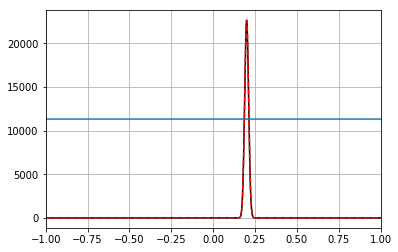

In [10]:
def gauss(t,A,mu, dt):
    tt= t- mu
    return A*np.exp(-4*np.log(2)*(tt*tt)/(dt*dt))

w = np.linspace(-1,1,100)
#omega axis

plt.plot(omega_p,np.abs(I_omega.real), color = 'black')
plt.xlim([-1,1])

popt,pcov = curve_fit(gauss,  omega_p, np.abs(I_omega.real), maxfev=10000)
plt.plot(omega_p,gauss(omega_p,*popt),'--',color = "red")

plt.plot(omega_p,gauss(popt[2]/2+popt[1],*popt)*time**0)
plt.grid()


In [11]:
print(popt)
dw  = popt[2]
print((dw*100)/(2*np.pi))

[2.26572686e+04 2.00354197e-01 2.77314332e-02]
0.4413594677852675


Now that we have corrected the Fourier Transform method, the result above comes out as expexted, 0.441.

## Task 2

Investagtion of the change in $\Delta{E}$ with CEP (Carier Envelope Phase).

$\Delta{E}$ is the maximum variation of the electric field withing a given wavepacket. We expect that for long wavepackets (many cicles) CEP does not affect $\Delta{E}$ whilst for short wavepackets (1-2 cycles) the oposite is true.

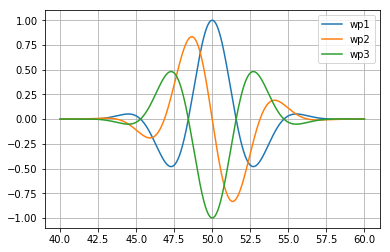

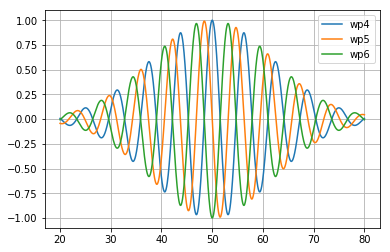

In [12]:
time = np.linspace(40,60,1000)
wp1 = wave_packet(time,dt = 4, omega = 1,lag = 50, b = 0, phi = 0)[0].real
wp2 = wave_packet(time,dt = 4, omega = 1,lag = 50, b = 0, phi = np.pi/2)[0].real
wp3 = wave_packet(time,dt = 4, omega = 1,lag = 50, b = 0, phi = np.pi)[0].real
plt.plot(time,wp1, label = "wp1")
plt.plot(time,wp2, label = "wp2")
plt.plot(time,wp3, label = "wp3")
plt.grid()
plt.legend()

time = np.linspace(20,80,1000)

wp4 = wave_packet(time,dt = 20, omega = 1,lag = 50, b = 0, phi = 0)[0].real
wp5 = wave_packet(time,dt = 20, omega = 1,lag = 50, b = 0, phi = np.pi/2)[0].real
wp6 = wave_packet(time,dt = 20, omega = 1,lag = 50, b = 0, phi = np.pi)[0].real

plt.figure()
plt.plot(time,wp4, label = "wp4")
plt.plot(time,wp5, label = "wp5")
plt.plot(time,wp6, label = "wp6")
plt.grid()
plt.legend()

We can now obtain the peaks of these functions

In [13]:
Epeak1 = np.max(wp1)
Epeak2 = np.max(wp2)

print(Epeak1)
print(Epeak2)

Epeak4 = np.max(wp4)
Epeak5 = np.max(wp5)

print(Epeak4)
print(Epeak5)

0.9999412190463061
0.8331865606284452
0.9995460085365376
0.9911392383363417


We can obviously see the difference in the peaks. We now need to make this more systematic. Let's see how we can get Epeak for an array of phases.

In [14]:
phases = np.arange(0,np.pi*2,np.pi/8)

#collect max's
Epeaks = []
for fi in phases:
    Epeaks.append(np.max(wave_packet(time,dt = 4, omega = 1,lag = 50, b = 0, phi = fi)[0].real))

deltaE = np.max(Epeaks) - np.min(Epeaks)
deltaE

0.519034107230234

In [15]:
#We now need to put the above into a bigger loop that varies dt

durations = np.arange(0.5,21,0.5)
deltaEs = []

for duration in durations:
    Epeaks = []
    for fi in phases:
        Epeaks.append(np.max(wave_packet(time,dt = duration, omega = 1,lag = 50, b = 0, phi = fi)[0].real))
    deltaEs.append(np.max(Epeaks) - np.min(Epeaks))

We can now plot $\Delta E$ against the cycles in order to determine the variation of $E$ with cycles

Text(0, 0.5, 'Max Variation as Fraction of $E$')

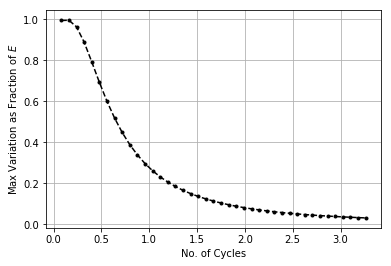

In [16]:
#plt.plot(durations,deltaEs)

#let's work out the cycles = dt / T
omega = 1
T = 2*np.pi / omega
cycles = durations / T
plt.plot(cycles,deltaEs,'.--',color = "Black")
plt.grid()
plt.xlabel("No. of Cycles")
plt.ylabel("Max Variation as Fraction of $E$")

### Task 3

Plot pulse spectrum on a wavelength scale – check that energy is conserved.

Now we want to convert to wavelength in order to plot we spectrum on a wavelength scale. 

(10, 100)

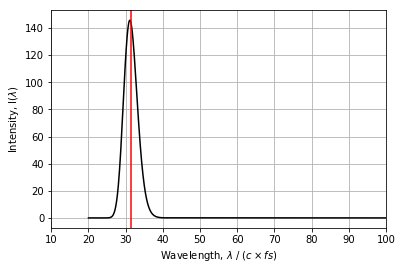

In [17]:
lambdas =[]
I_lambda =[]
I_omega = np.abs(I_omega.real)

width = 300
zipped = zip(omega_p[5200-width:5200+width],I_omega[5200-width:5200+width])
#zipped = zip(omega_p,I_omega)
for w,I_w in zipped:
    lambdas.append(2*np.pi/np.abs(w))
    I_lambda.append(I_w*w**2/(2*np.pi))
    
plt.plot(lambdas,I_lambda, color = 'black')
plt.axvline(2*np.pi/0.2,color = "red")
plt.grid()
#plt.axis([0,2500,0,0.01])
plt.xlabel("Wavelength, $\lambda$ / $(c \\times fs)$")
plt.ylabel("Intensity, I($\lambda$)")
plt.xlim([10,100])

We can now integrate the above (I($\lambda$)) in order to check energy conservation, by comparing it with the integral of the angular frequency (I($\omega$)) graph.

In [18]:
print(np.trapz(np.asarray(I_lambda),np.asarray(lambdas)))
print(np.trapz(omega_p[5100-width:5100+width],np.abs(I_omega[5100-width:5100+width])))

-668.8310021391379
-668.2783433581782


The two values are very similar, indicating that indeed energy is conserved. 

### Task 4

Create a function that can sum an arbitrary number of Gaussian wavepackets.
Such a function must take as arguments the parameters of all wavepackets.

In [19]:
def pulse(time,X):
    '''
    X is a nested list that contained the parameters of each Gaussian wavepackets
    E.g. X = [params1,params2,params3] where paramsi = [dti,omegai,lagi,bi,phii]
    '''
    E = 0
    I = 0
    Phase = 0
    for params in X:
        E += wave_packet(time,dt = params[0], omega = params[1],lag = params[2], b = params[3], phi = params[4])[0]
        
    return E,np.absolute(E)**2

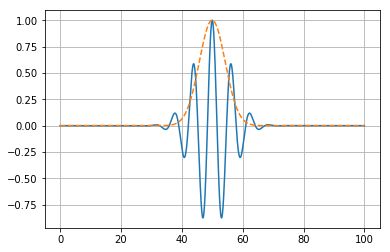

In [20]:
params1 = [10,1,50,0,0]
X = [params1]
time = np.linspace(0,100,1000)

plt.plot(time,pulse(time,X)[0].real)
plt.plot(time,pulse(time,X)[1].real,"--")
plt.grid()

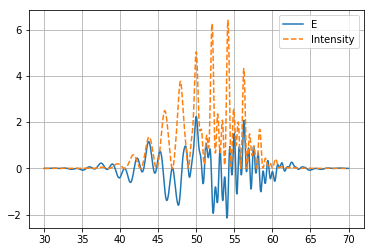

In [21]:
params1 = [10,1,50,0,0]
params2 = [10,4,50,0,0]
params3 = [5,10,55,0,0]
X = [params1,params2,params3]
time = np.linspace(30,70,1000)

plt.plot(time,pulse(time,X)[0].real, label = "E")
plt.plot(time,pulse(time,X)[1].real,"--", label = "Intensity")
plt.grid()
plt.legend()

The arbitrary addition seems to work well. We can now define a more straight-forward function (one that simply adds a specific number of wavepackets) and compares the running time of the two.

In [22]:
def pulse_s(time,X):
    E =  wave_packet(time,dt = X[0], omega = X[1],lag = X[2],
                       b = X[3], phi = X[4])[0] + wave_packet(time,
                    dt = X[5], omega = X[6],lag = X[7], b = X[8],
                phi = X[9])[0]+ wave_packet(time,dt = X[10], omega = X[11],lag = X[12], b = X[13], phi = X[14])[0]
    return E,np.absolute(E)**2

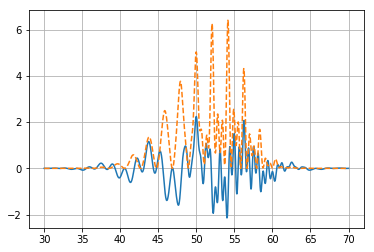

In [23]:
params1 = [10,1,50,0,0]
params2 = [10,4,50,0,0]
params3 = [5,10,55,0,0]
X = params1 + params2 + params3
time = np.linspace(30,70,1000)
plt.plot(time,pulse_s(time,X)[0].real, label = "E")
plt.plot(time,pulse_s(time,X)[1],"--", label = "Intensity")
plt.grid()

We can now time the two functions to determine which is the fastest.

In [24]:
#the two functions produce the same thing as expected. But which one is the fastest?
#we can run them many times and measure the total time
params1 = [10,1,50,0,0]
params2 = [10,4,50,0,0]
params3 = [5,10,55,0,0]
X = [params1,params2,params3]

def run1():
    for i in range(100000):
        pulse(5,X)
        
%time run1()

CPU times: user 2.73 s, sys: 8.48 ms, total: 2.74 s
Wall time: 2.74 s


In [25]:
params1 = [10,1,50,0,0]
params2 = [10,4,50,0,0]
params3 = [5,10,55,0,0]
X = params1 + params2 +params3

def run2():
    for i in range(100000):
        pulse_s(5,X)
        
%time run2()

CPU times: user 2.63 s, sys: 6.45 ms, total: 2.63 s
Wall time: 2.63 s


In [26]:
times1 = [19.4,18.9,18.9,19.1,19.2] #1E6 times
times2 = [18.7,18.8,18.7,18.8,18.6]

print(np.mean(times1),np.mean(times2))

times1 = [1.95,1.91,1.91,1.91,1.92] #1E6 times
times2 = [1.89,1.89,1.92,1.90,1.91]

print(np.mean(times1),np.mean(times2))

19.1 18.72
1.92 1.902


We can see that the two times are very similar, so the two methods are more or less equal in speed.

### Task 5

Developing a Cost Function

An attempt is made here to code our own cost function, based on summing the difference between pulse and target at various points.
This is exactly the same as integrating which is suggested in the given paper.
We start by considering only one wavepacket. 

In [27]:
def cost(X,time_domain,target):
    return np.sum(np.absolute(target - wave_packet(time_domain,*X)[0]))

The above cost function just takes the difference between the target and the given wavepacket. 

293.8801012179339


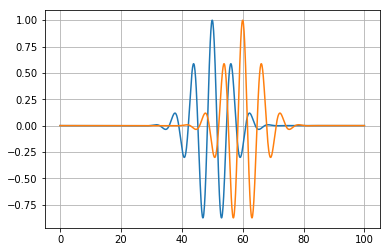

In [28]:
N = 1000
time_domain = 100
time = np.linspace(0,time_domain,N)
wv1 = wave_packet(time,dt = 10,omega = 1,lag = 50,b =0.00 ,phi = 0)[0]
plt.plot(time,wv1.real)

#consider taking wv1 as the target and comparing it with another wave with the following parameters
X = [10,1,60,0,0]
#this is the same pulse but displaced to the right by 10 fs
plt.plot(time,wave_packet(time,*X)[0].real)
plt.grid()
print(cost(X,time,wv1))

We can now use our cost function to evaluate the difference between the two pulses.

We can move the second pulse about sto establish whether the function is working correctly. (We expect a zero value when we superimpose the two pulses and a max value when we separate them completely).

293.8801012179339
201.45954761994673
0.0


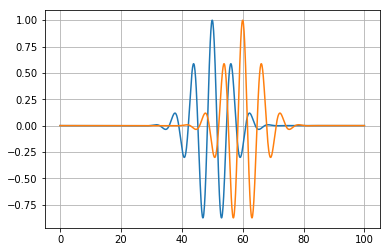

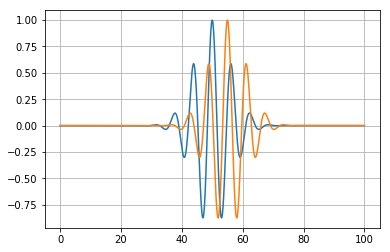

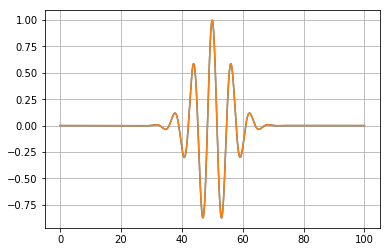

In [29]:
X = [10,1,60,0,0]
print(cost(X,time,wv1))

plt.plot(time,wv1)
plt.plot(time,wave_packet(time,*X)[0].real)
plt.grid()

X = [10,1,55,0,0]
print(cost(X,time,wv1))

plt.figure()
plt.plot(time,wv1)
plt.plot(time,wave_packet(time,*X)[0].real)
plt.grid()

X = [10,1,50,0,0]
print(cost(X,time,wv1))

plt.figure()
plt.plot(time,wv1)
plt.plot(time,wave_packet(time,*X)[0].real)
plt.grid()

This straight forward cost function seems to work well. We can now try to use it to solve for the parameter of the target ($X$) using a minimisation routine.

In [30]:
N = 1000
time = np.linspace(0,100,N)

wv1 = wave_packet(time,dt = 10,omega = 1,lag = 50,b =0.00 ,phi = 0)[0]
#X = [10,1,50,0,0]
x = minimize(cost,x0 = [11,1,55,0,0],args = (time,wv1),method='CG').x
x

array([ 9.99377244e+00,  9.99999891e-01,  5.00039560e+01, -8.88131070e-08,
       -6.27922478e+00])

/Users/marioskassapis/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


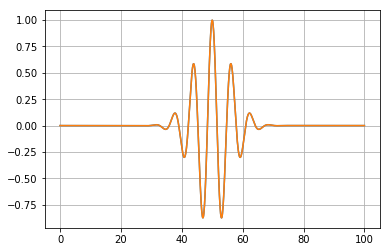

In [31]:
#wv1 = wave_packet(time,dt = 10,omega = 1,lag = 50,b =0.00 ,phi = 0)[0]
plt.plot(time,wv1)
plt.plot(time,wave_packet(time,*x)[0])
plt.grid()

Notes:

- We have developed a cost function to compare a Gaussian wavepacket to an arbitrary target.
- We began with the easiest target: another Gaussian wavepacket
- The optimization routine can sometimes find the target but other times fails to do so and returns a zero field wavepacket. This is a matter of how close the initial conditions are to the target.
- Below we can try the same with more difficult targets.
- We also need a minimisation technique which is better for many dimensions e.g. simulated annealing.

#### Cost function and Simmulated annealing

Below we will do as before but using the simmulated annealing routine provided by SciPy.

Apparently, SciPy has stopped supporting simmulated annealing. Instead the documenation suggests using the Basin-Hopping algorithm. This can be summarised in the following steps:

1. Random perturbation of the coordinates
2. Local minimization
3. Accept or Reject the new coordinates based on the minimized function value

The fact the new coordinated can be rejected allows the algorithm to continue searching until a $\textit{global}$ minimum is found.

In [32]:
bsn(cost,x0 = [11,1,55,0,0],minimizer_kwargs = {"args":(time,wv1)})

                        fun: 1.0845224346903477e-05
 lowest_optimization_result:       fun: 1.0845224346903477e-05
 hess_inv: array([[ 7.01522263e-07, -5.28095164e-09,  4.34411577e-07,
         4.82656168e-09,  3.78569216e-07],
       [-5.28095164e-09,  1.04021011e-10, -3.32195545e-09,
        -4.14356885e-11, -2.83257496e-09],
       [ 4.34411577e-07, -3.32195545e-09,  2.98738971e-07,
         3.45727876e-09,  2.63616318e-07],
       [ 4.82656168e-09, -4.14356885e-11,  3.45727876e-09,
         5.43558212e-11,  2.95878693e-09],
       [ 3.78569216e-07, -2.83257496e-09,  2.63616318e-07,
         2.95878693e-09,  2.34016828e-07]])
      jac: array([   5.04882722,  354.39824701,  -50.94074713, 4750.166451  ,
         68.67876849])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1160
      nit: 59
     njev: 164
   status: 2
  success: False
        x: array([-9.99999987e+00,  1.00000000e+00,  5.00000001e+01, -1.88194011e-09,
       -6.28318517e+00])
 

We can not plot the parameters obtained by the above Basin-Hopping in order to visualise the wavepacket.

/Users/marioskassapis/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


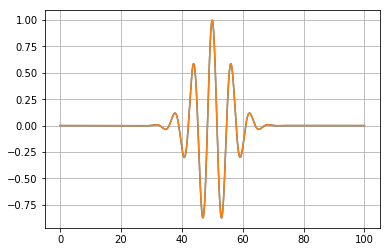

In [33]:
x= [ 1.00000001e+01,  1.00000001e+00,  5.00000000e+01, -7.91553159e-10,
       -8.97008951e-08]
plt.plot(time,wv1)
plt.plot(time,wave_packet(time,*x)[0])
plt.grid()

Let's try using bad initial conditions to see if the algorithm can cope:

In [34]:
bsn(cost,x0 = [5,5,51,0.2,np.pi],minimizer_kwargs = {"args":(time,wv1)})

                        fun: 1.552226048669567e-05
 lowest_optimization_result:       fun: 1.552226048669567e-05
 hess_inv: array([[ 2.25126687e-07, -5.70547748e-09,  1.16524664e-07,
        -6.46883257e-10,  1.43386078e-07],
       [-5.70547748e-09,  1.67665936e-10, -3.15450762e-09,
         1.16249039e-11, -3.83851017e-09],
       [ 1.16524664e-07, -3.15450762e-09,  8.36888486e-08,
        -5.39273445e-10,  1.09203819e-07],
       [-6.46883257e-10,  1.16249039e-11, -5.39273445e-10,
         9.10659491e-12, -7.83304820e-10],
       [ 1.43386078e-07, -3.83851017e-09,  1.09203819e-07,
        -7.83304820e-10,  1.50301033e-07]])
      jac: array([   9.51773622,  459.58160946,  -22.45110969, 4273.35754404,
         53.65327393])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 942
      nit: 48
     njev: 133
   status: 2
  success: False
        x: array([-9.99999933e+00,  1.00000001e+00,  5.00000005e+01, -1.38258162e-09,
        5.46649463e-07])
    

/Users/marioskassapis/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


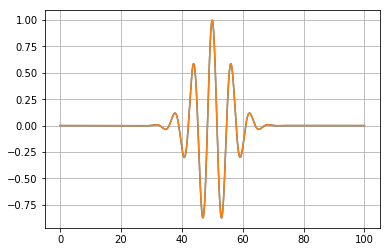

In [35]:
x= [ 9.99999950e+00,  9.99999988e-01,  5.00000000e+01,  2.12237435e-11,
       -1.19630872e-10]
plt.plot(time,wv1)
plt.plot(time,wave_packet(time,*x)[0])
plt.grid()

So the wavepacket can be reproduced, even with quite bad initial conditions, as shown above.

### Week 3

### Task 

Write a function to find the centre of energy of the pulse.

Text(0, 0.5, 'Amplitude')

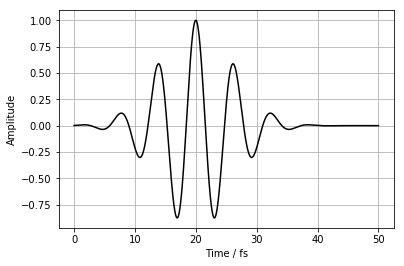

In [37]:
time = np.linspace(0,50,10000)
wp1 = wave_packet(time,dt = 10,omega = 1,lag = 20,b =0.0 ,phi = 0)

plt.plot(time,wp1[0], color = "black")
plt.grid()
plt.xlabel("Time / fs")
plt.ylabel("Amplitude")

In [38]:
def CoM(time, function):
    
    num = 0
    den = 0
    
    for i in range(len(time)):
        
        num += time[i] * np.absolute(function[i])
        den += np.absolute(function[i])
        
    #print(num)
    #print(den)
        
    return (num / den)

In [39]:
CoM(np.linspace(0,50,10000),wp1[0].real)

20.007672902070695

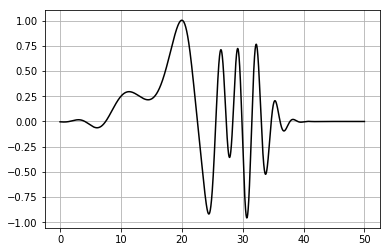

In [40]:
arb_wave = wave_packet(time,dt = 10,omega = 0.5,lag = 20,b =0.05 ,phi = 0)[0]+wave_packet(time,dt = 5,omega = 2,lag = 30,b =0.0 ,phi = np.pi/2)[0]+wave_packet(time,dt = 5,omega = 0.02,lag = 30,b =0.0 ,phi = np.pi/2)[0]
plt.plot(time,arb_wave, color = 'black')
plt.grid()

In [41]:
CoM(time, arb_wave)

23.314077702839253

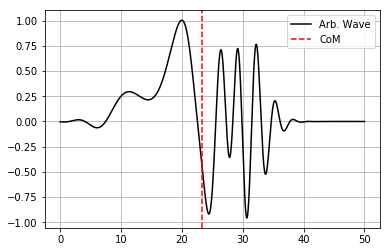

In [42]:
plt.plot(time,arb_wave, color = 'black', label = "Arb. Wave")
plt.axvline(CoM(time,arb_wave), color = 'red', label = 'CoM', linestyle ='--')
plt.legend()
plt.grid()

### Task - Extend basin hopping to more than 1 pulse (try 2 and then 3)


Here we will examine how the BH algorithm fares when needed to feed something all 15 free parameters.

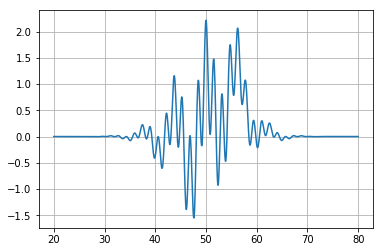

In [43]:
#for this we need a composite pulse
def pulse(time,X):
    E =  wave_packet(time,dt = X[0], omega = X[1],lag = X[2],
                       b = X[3], phi = X[4])[0] + wave_packet(time,
                    dt = X[5], omega = X[6],lag = X[7], b = X[8],
                phi = X[9])[0]+ wave_packet(time,dt = X[10], omega = X[11],lag = X[12], b = X[13], phi = X[14])[0]
    return E

def cost(X,time_domain,target):
    return np.sum(np.absolute(target - pulse(time_domain,X)))

#we will define a target pulse and then see if the algorithm can get it
params1 = [10,1,50,0,0]
params2 = [10,4,50,0,0]
params3 = [5,0.1,55,0,0]

X = params1 + params2 + params3
time = np.linspace(20,80,1000)
plt.plot(time,pulse(time,X).real)
plt.grid()

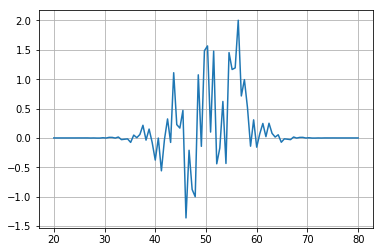

In [45]:
#now we need to use this pulse to create a target of 100 points
time = np.linspace(20,80,100)
target1 = pulse(time,X)
plt.plot(time,target1, label = "Target")
plt.grid()

In [46]:
time = np.linspace(20,80,100)
target1 = pulse(time,X)


params1 = [11,1,51,0,0]
params2 = [10,4.2,53,0,0]
params3 = [5,0.1,55,0,0]

X0 = params1 + params2 + params3

bsn(cost,x0 = X0,minimizer_kwargs = {"args":(time,target1)},disp = True)

basinhopping step 0: f 2.88942e-05
basinhopping step 1: f 2.47917e-05 trial_f 2.47917e-05 accepted 1  lowest_f 2.47917e-05
found new global minimum on step 1 with function value 2.47917e-05
basinhopping step 2: f 2.47917e-05 trial_f 8.44638 accepted 0  lowest_f 2.47917e-05
basinhopping step 3: f 2.92074e-05 trial_f 2.92074e-05 accepted 1  lowest_f 2.47917e-05
basinhopping step 4: f 1.99265e-05 trial_f 1.99265e-05 accepted 1  lowest_f 1.99265e-05
found new global minimum on step 4 with function value 1.99265e-05
basinhopping step 5: f 1.99265e-05 trial_f 23.1432 accepted 0  lowest_f 1.99265e-05
basinhopping step 6: f 3.34542e-05 trial_f 3.34542e-05 accepted 1  lowest_f 1.99265e-05
basinhopping step 7: f 3.34542e-05 trial_f 21.1007 accepted 0  lowest_f 1.99265e-05
basinhopping step 8: f 3.34542e-05 trial_f 21.825 accepted 0  lowest_f 1.99265e-05
basinhopping step 9: f 3.34542e-05 trial_f 21.9985 accepted 0  lowest_f 1.99265e-05
basinhopping step 10: f 3.34542e-05 trial_f 22.4323 accepted

basinhopping step 59: f 3.66163e-05 trial_f 3.66163e-05 accepted 1  lowest_f 1.56082e-05
basinhopping step 60: f 3.66163e-05 trial_f 22.0794 accepted 0  lowest_f 1.56082e-05
basinhopping step 61: f 3.66163e-05 trial_f 23.0343 accepted 0  lowest_f 1.56082e-05
basinhopping step 62: f 1.98122e-05 trial_f 1.98122e-05 accepted 1  lowest_f 1.56082e-05
basinhopping step 63: f 1.98122e-05 trial_f 24.9413 accepted 0  lowest_f 1.56082e-05
basinhopping step 64: f 1.98122e-05 trial_f 8.44661 accepted 0  lowest_f 1.56082e-05
basinhopping step 65: f 3.66398e-05 trial_f 3.66398e-05 accepted 1  lowest_f 1.56082e-05
basinhopping step 66: f 3.66398e-05 trial_f 21.8248 accepted 0  lowest_f 1.56082e-05
basinhopping step 67: f 3.18753e-05 trial_f 3.18753e-05 accepted 1  lowest_f 1.56082e-05
basinhopping step 68: f 3.18753e-05 trial_f 8.44939 accepted 0  lowest_f 1.56082e-05
basinhopping step 69: f 2.98526e-05 trial_f 2.98526e-05 accepted 1  lowest_f 1.56082e-05
basinhopping step 70: f 2.98526e-05 trial_f 8

                        fun: 1.5568489217495e-05
 lowest_optimization_result:       fun: 1.5568489217495e-05
 hess_inv: array([[ 1.49295910e-05, -1.67561125e-08,  8.52341643e-06,
         1.07387059e-08,  7.44072558e-06,  8.45966903e-06,
         2.36054284e-09, -5.09631609e-06, -2.60146120e-09,
        -2.06292683e-05, -1.92327856e-06,  5.12720183e-08,
         1.01541008e-06, -1.21250794e-07,  3.42987834e-07],
       [-1.67561125e-08,  7.88626065e-09, -1.36325791e-08,
         3.71847861e-10, -1.94376996e-08,  4.26155972e-08,
         2.74063494e-09, -1.58012515e-07,  6.33016931e-11,
        -6.53843541e-07,  3.46566513e-08,  6.46695208e-09,
        -1.71560119e-08,  2.86900350e-09, -2.79011233e-08],
       [ 8.52341643e-06, -1.36325791e-08,  1.19125589e-05,
        -4.76195926e-09,  1.17749190e-05,  1.24224982e-05,
         9.92165631e-09, -5.76241586e-06,  1.79687592e-08,
        -2.40778513e-05, -4.08764100e-06,  2.54198758e-07,
        -4.75252829e-06, -3.39866528e-08, -8.0258245

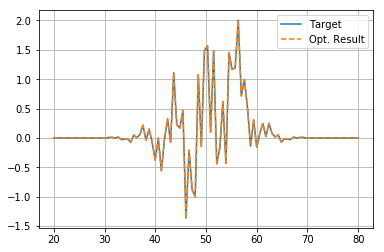

In [48]:
Xres = [ 1.00000012e+01,  9.99999928e-01,  5.00000003e+01, -1.10343531e-08,
       -6.28318490e+00,  9.99999842e+00,  4.00000000e+00,  4.99999981e+01,
       -7.14228598e-09, -1.25663779e+01, -4.99999980e+00,  1.00000122e-01,
        5.49999992e+01, -7.39581510e-08, -6.28318503e+00]

time = np.linspace(20,80,100)

plt.plot(time,target1, label = "Target")
plt.plot(time,pulse(time,Xres),"--", label = "Opt. Result")
plt.grid()
plt.legend()

The method seems to have worked but took quite long. Also the initial conditions were not far from the target so perhaps we have helped the algorithm a bit too much.

On the other hand, the algorithm ran until the value of the cost function was of the order of 1E-5. Which is perhaps excessive. We will therefore try to define our one criteria for success and try again:

In [49]:
def stop(x,f,accept):
    if f < 1:
        return True
    
params1 = [11,5,51,0,0]
params2 = [10,7.2,53,0,np.pi]
params3 = [10,0.1,55,0.01,0]
X0 = params1 + params2 + params3

a = bsn(cost,x0 = X0,minimizer_kwargs = {"args":(time,target1)},disp = True, callback = stop)
Xres = a.x
print(Xres)

basinhopping step 0: f 29.64
basinhopping step 1: f 12.4199 trial_f 12.4199 accepted 1  lowest_f 12.4199
found new global minimum on step 1 with function value 12.4199
basinhopping step 2: f 8.44686 trial_f 8.44686 accepted 1  lowest_f 8.44686
found new global minimum on step 2 with function value 8.44686
basinhopping step 3: f 8.44686 trial_f 20.2751 accepted 0  lowest_f 8.44686
basinhopping step 4: f 0.000182864 trial_f 0.000182864 accepted 1  lowest_f 0.000182864
found new global minimum on step 4 with function value 0.000182864
[-9.99999462e+00  4.00000000e+00  4.99999761e+01 -1.58617975e-08
 -9.55351290e-05  9.99995827e+00  1.13672557e+01  4.99999530e+01
  2.30668393e-08 -2.19916844e+01  4.99997836e+00  1.00000724e-01
  5.49999912e+01  7.97053935e-07  6.28317884e+00]


/Users/marioskassapis/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


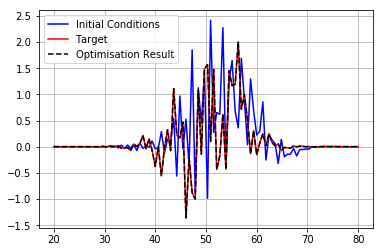

In [50]:
time = np.linspace(20,80,100)
plt.plot(time,pulse(time,X0),label = "Initial Conditions",color = "blue")
plt.plot(time,target1,label = "Target",color = "red")
plt.plot(time,pulse(time,Xres),"--",color = "black",label = "Optimisation Result")
plt.grid()
plt.legend()

In [52]:
#can now do the same with even worst ICs (Initial Conditions).

params1 = [11,5,41,1,2]
params2 = [1,7.2,53,0.5,np.pi]
params3 = [100,0.1,65,0.01,0]
X0 = params1 + params2 + params3

%time a = bsn(cost,x0 = X0,minimizer_kwargs = {"args":(time,target1)},disp = True, callback = stop)
Xres = a.x
print(Xres)

basinhopping step 0: f 31.1139
basinhopping step 1: f 31.1139 trial_f 31.4402 accepted 0  lowest_f 31.1139
basinhopping step 2: f 30.2907 trial_f 30.2907 accepted 1  lowest_f 30.2907
found new global minimum on step 2 with function value 30.2907
basinhopping step 3: f 30.2907 trial_f 30.888 accepted 0  lowest_f 30.2907
basinhopping step 4: f 30.2907 trial_f 32.9591 accepted 0  lowest_f 30.2907
basinhopping step 5: f 30.2907 trial_f 32.4865 accepted 0  lowest_f 30.2907
basinhopping step 6: f 31.1404 trial_f 31.1404 accepted 1  lowest_f 30.2907
basinhopping step 7: f 24.7955 trial_f 24.7955 accepted 1  lowest_f 24.7955
found new global minimum on step 7 with function value 24.7955
basinhopping step 8: f 24.7955 trial_f 27.3698 accepted 0  lowest_f 24.7955
basinhopping step 9: f 24.2297 trial_f 24.2297 accepted 1  lowest_f 24.2297
found new global minimum on step 9 with function value 24.2297
basinhopping step 10: f 24.2297 trial_f 27.3151 accepted 0  lowest_f 24.2297
basinhopping step 11

basinhopping step 64: f 27.9774 trial_f 30.13 accepted 0  lowest_f 24.2297
basinhopping step 65: f 27.9774 trial_f 29.438 accepted 0  lowest_f 24.2297
basinhopping step 66: f 27.9774 trial_f 31.391 accepted 0  lowest_f 24.2297
basinhopping step 67: f 26.3779 trial_f 26.3779 accepted 1  lowest_f 24.2297
basinhopping step 68: f 26.3779 trial_f 29.8557 accepted 0  lowest_f 24.2297
basinhopping step 69: f 26.3779 trial_f 28.9252 accepted 0  lowest_f 24.2297
basinhopping step 70: f 26.3779 trial_f 30.4324 accepted 0  lowest_f 24.2297
basinhopping step 71: f 26.3779 trial_f 27.7883 accepted 0  lowest_f 24.2297
basinhopping step 72: f 26.3779 trial_f 31.9929 accepted 0  lowest_f 24.2297
basinhopping step 73: f 26.5252 trial_f 26.5252 accepted 1  lowest_f 24.2297
basinhopping step 74: f 26.5252 trial_f 30.2579 accepted 0  lowest_f 24.2297
basinhopping step 75: f 26.3323 trial_f 26.3323 accepted 1  lowest_f 24.2297
basinhopping step 76: f 26.3323 trial_f 32.4039 accepted 0  lowest_f 24.2297
bas

/Users/marioskassapis/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


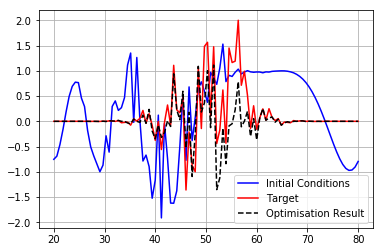

In [53]:
time = np.linspace(20,80,100)
plt.plot(time,pulse(time,X0),label = "Initial Conditions",color = "blue")
plt.plot(time,target1,label = "Target",color = "red")
plt.plot(time,pulse(time,Xres),"--",color = "black",label = "Optimisation Result")
plt.grid()
plt.legend()

### Task - Write your own genetic algorithm code and compare to basin hopping in terms of speed, robustness to initial parameters etc

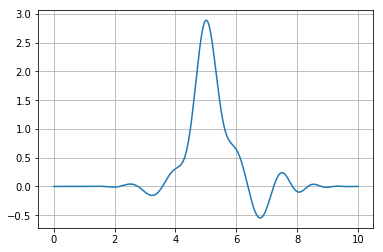

In [9]:
def wave_packet(absolute_time,dt = 10,omega = 1,lag = 20,b =0.1 ,phi = 1):
    '''
    For a value of absolute time, returns electric field amplitude of the wavepacket
    defined by passed parameters.
    '''
    t = absolute_time - lag
    E = np.exp((omega*t + b*t*t + phi)*1j)*np.exp(-(t*t)*2*np.log(2)/(dt*dt))
    return E#,np.absolute(E)**2, b*t*t + phi

#for this we need a composite pulse
#for this we need a composite pulse
def pulse(time,X):
    E =  wave_packet(time,dt = X[0], omega = X[1],lag = X[2],
                       b = X[3], phi = X[4])[0] + wave_packet(time,
                    dt = X[5], omega = X[6],lag = X[7], b = X[8],
                phi = X[9])[0]+ wave_packet(time,dt = X[10], omega = X[11],lag = X[12], b = X[13], phi = X[14])[0]
    return E

def pulse(time,X):
    '''
    X is a nested list that contained the parameters of each Gaussian wavepackets
    E.g. X = [params1,params2,params3] where paramsi = [dti,omegai,lagi,bi,phii]
    '''
    E = 0
    I = 0
    Phase = 0
    for params in X:
        E += wave_packet(time,dt = params[0], omega = params[1],lag = params[2], b = params[3], phi = params[4])
        
    return E
    


def cost(X,time_domain,target):
    return np.sqrt(np.sum(np.absolute(target - pulse(time_domain,X))**2))

#we will define a target pulse and then see if the algorithm can get it
params1 = [1,1,5,0,0]
params2 = [1,4,5,0,0]
params3 = [2,1,5.5,1,0]

'''
[ 2.07526734  0.60984148  5.27283178  0.90129598 -0.0830808 ]
[ 0.9799802   2.49506646  4.99072929 -0.65115082  6.2296787 ]
[-0.16159486  3.72776599 10.39030196 -1.64669857  3.79206414]
'''

X = [params1,params2,params3]
time = np.linspace(0,10,1000)
plt.plot(time,pulse(time,X).real)
plt.grid()
#make this our target for today
target1 = pulse(time,X)

Now we define all the functions that are to be used in the genetic algorithm:

- Generating a pulse (initial population)
- Finding initial parent
- Mutating 
- Getting the new generation

In [10]:
#fist we need a function to generate a random pulse
def gen_pulse(n = 3,dt1 = 0.1,dt2 = 10,w1 = 0.01, w2 = 20, lag1 = 0, lag2 = 10, b1 = 0,b2 = 1):
    '''
    This function randomly generates the parameters for a pulse composed of n gaussian wavepackets
    '''
    Xrand = []
    for i in range(n):
        list1 = [uniform(dt1,dt2),uniform(w1,w2),uniform(lag1,lag2),uniform(b1,b2),uniform(0,np.pi*2)]
        Xrand.append(list1)
    return Xrand

def find_initial_parent(N,target):
    children = []
    for i in range(N):
        children.append(gen_pulse())
    #print(children)
    costs = []
    for child in children:
        costs.append(cost(child,time,target))
    costs.sort()
    #print(costs)
    fit_children = []
    
    for child in children:
        if cost(child,time,target) <= costs[1]:
            fit_children.append(child)
    #print(fit_children)
    return (np.asarray(fit_children[0]) + np.asarray(fit_children[1])) / 2

def mutate(child,step = [1,1,1,1,1]):
    mutation = np.copy(child)
    for param in mutation:
        param += [(random()-0.5)*step[0],(random()-0.5)*step[1],(random()-0.5)*step[2],(random()-0.5)*step[3],
                  (random()-0.5)*step[4]]
    return mutation

def new_gen(parent,target,N = 200,step = [1,1,1,1,1], show = False):

    children2 = []
    for i in range(N):
        children2.append(mutate(parent,step))

    costs = []
    for child in children2:
        costs.append(cost(child,time,target))
    costs.sort()
    #print(costs)
    
    fit_children2 = []
    for child in children2:
        if cost(child,time,target) <= costs[1]:
            fit_children2.append(child)
            
    result = (np.asarray(fit_children2[0]) + np.asarray(fit_children2[1]))/2
    if show == True:
        print("Cost is "+str(cost(result,time,target)))
    return result

In [56]:
result = find_initial_parent(10,target1)
print(result)

[[ 3.14757402 12.5817009   5.47478905  0.55890326  3.29424393]
 [ 7.0445496  12.12564801  6.07504353  0.5243937   4.11140991]
 [ 6.25530339 13.87075092  7.78113751  0.54503381  1.44414224]]


C:\Users\George\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


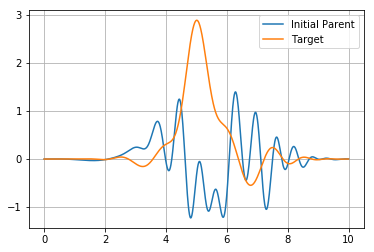

In [11]:
result = find_initial_parent(1000,target1)
plt.plot(time,pulse(time,result), label = "Initial Parent")
plt.plot(time,target1, label = "Target")
plt.grid()
plt.legend()

Cost is 28.12098011320109
Cost is 27.95537122715044
Cost is 27.7462263529206
Cost is 27.592687068760604
Cost is 27.444773091523707
Cost is 27.30125719160314
Cost is 27.104879530479565
Cost is 26.966383511068557
Cost is 26.793214409948714
Cost is 26.646769412245547
[[ 1.39421862 11.95821679  5.94942541  0.47378722  2.13144788]
 [ 1.16999856  2.72215664  4.57000295  0.7681426   4.68777821]
 [ 0.01804295 11.16653631  3.32193922  0.14869993  5.08948059]]


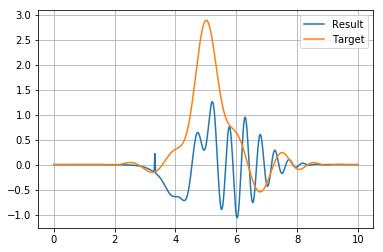

In [60]:
step_param = np.array([0.1,0.1,0.1,0.01,0.1])
for i in range(10):
    result = new_gen(N = 50,target = target1, parent = result,step = step_param*1,show = True)
plt.plot(time,pulse(time,result),label = "Result")
plt.plot(time,target1, label = "Target")
plt.grid()
plt.legend()
print(result)

In [61]:
print(result)
cost(result,time,target1)

[[ 1.39421862 11.95821679  5.94942541  0.47378722  2.13144788]
 [ 1.16999856  2.72215664  4.57000295  0.7681426   4.68777821]
 [ 0.01804295 11.16653631  3.32193922  0.14869993  5.08948059]]


26.646769412245547

We see that our Genetic Algorithm has struck a local minimum and has a really hard time getting out of it. This is where we need to start tuning the algorithm, primarily by making the step parameter different for each variable. (That is how it should be but we started with a single step for simplicity).

We now define what will be our new target function, the so-called $perfect$ $wave$, which is a shifted saw-tooth function. 

In [12]:
def perfect_wave(A, T, time, lag):
    
    t = time - lag
    
    if t < T and t > 0:
        
        E = A*((3*t)/T - 1) 
        
    #elif t > T and t < 2*T:
    #    
    #    E = A*((3*(t-T))/T - 1) 
        
    else:
        
        E = 0
        
    return E

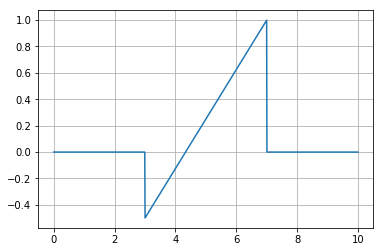

In [13]:
time = np.linspace(0,10,1000)
pw=  []
for t in time:
    pw.append(perfect_wave(0.5,4,t,3))
    
pw = np.asarray(pw)
plt.plot(time,pw)
plt.grid()

C:\Users\George\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


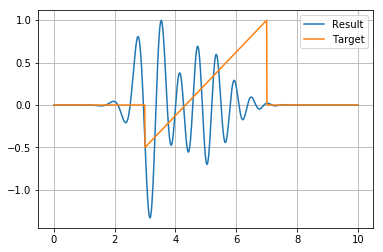

In [14]:
result = find_initial_parent(1000,pw)
plt.plot(time,pulse(time,result), label = "Result")
plt.plot(time,pw, label = "Target")
plt.legend()
plt.grid()

In [15]:
print(cost(result,time,pw))

16.9438561798438


Cost is 10.52091590786643
Cost is 10.503137083083095
Cost is 10.482095465386717
Cost is 10.467720477098728
Cost is 10.44292042973426
Cost is 10.44374122690204
Cost is 10.390893904744585
Cost is 10.374315523049024
Cost is 10.379286376145673
Cost is 10.356755204195117
[[ 1.05822657e+00  7.38292490e+00  3.24530806e+00  4.84159336e-01
   2.54042325e+00]
 [ 1.07946653e+00  7.24141663e+00  3.01438131e+00  5.15901594e-01
   3.88215146e+00]
 [-5.04576794e-03  9.12826785e+00  7.50523149e+00  7.90533127e-02
   1.09619958e+00]]
10.356755204195117


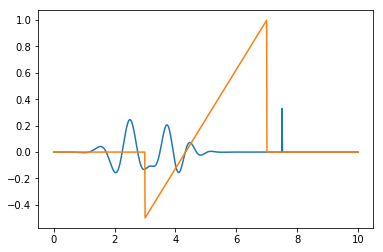

In [94]:
step_param = np.array([0.1,0.1,0.1,0.01,0.1])
for i in range(10):
    result = new_gen(N = 200,parent = result,target = pw,step = step_param*1,show = True)
plt.plot(time,pulse(time,result))
plt.plot(time,pw)
print(result)
print(cost(result,time,pw))

In [95]:
cost(result,time,pw)

10.356755204195117

In doing this many times, obviously the result defers. Below we save some good solutions in which we managed to recover a good perfect wave.

In [17]:
#save good solutions:
result1 = np.array([[ 12.10297182,  -7.8241418 ,  31.08689807,  -2.32370094,
         12.10839669],
       [  1.19689423,   0.84997027,   6.22350553,   1.17221199,
         -0.76273212],
       [  9.34144985,  24.69002642,  25.44060835,  -1.19480551,
        -17.52100813]])
result2 = np.array([[ 2.55369367, 19.10447244, 15.37642812,  6.42435659,  6.0211086 ],
       [ 1.21640122,  0.84374435,  6.21892739,  1.1369785 ,  5.54215174],
       [ 3.90388775, 10.73124998, 17.2320496 ,  7.15874286,  7.58864811]])

result3 = np.array([[ 1.22672893e+00,  9.00123226e-01,  1.12472979e+01,
         1.14846601e+00, -7.29839604e-01],
       [-5.48252819e-03,  1.46538880e+01,  1.72869642e+01,
         6.97185122e-01,  8.48394844e-01],
       [ 1.51688738e-01,  2.16771098e+01,  8.38130980e+00,
         1.86462084e+00, -1.43950222e-01]])
result4 = np.array([[ 2.20870304e-01,  5.29583821e+00,  1.20041962e+01,
        -1.01600036e-01,  1.52451825e+00],
       [-1.18769111e+00,  6.33326675e-01,  1.11576633e+01,
         9.19667230e-01, -7.91250637e-01],
       [-2.17186341e-03,  1.98378794e+00,  1.69394220e+01,
         6.11644676e-01,  4.64435540e+00]])

C:\Users\George\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


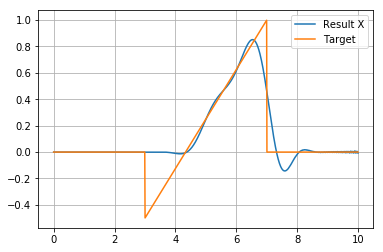

In [18]:
plt.plot(time,pulse(time,result2), label = "Result X")
plt.plot(time,pw, label = "Target")
plt.grid()
plt.legend()

### Week 4

### Genetic Algorithm with Physical Bounds

We will re-write the relevant functions so that the values of some parameters remain fixed and other remain within physical bounds.

In [33]:
def wave_packet(absolute_time,A = 1,dt = 10,omega = 1,lag = 20,b =0.1 ,phi = 1):
    '''
    For a value of absolute time, returns electric field amplitude of the wavepacket
    defined by passed parameters.
    '''
    t = absolute_time - lag
    E = A*np.exp((omega*t + b*t*t + phi)*1j)*np.exp(-(t*t)*2*np.log(2)/(dt*dt))
    return E#,np.absolute(E)**2, b*t*t + phi

#for this we need a composite pulse
#for this we need a composite pulse

def pulse(time,X):
    '''
    X is a nested list that contained the parameters of each Gaussian wavepackets
    E.g. X = [params1,params2,params3] where paramsi = [dti,omegai,lagi,bi,phii]
    '''
    E = 0
    I = 0
    Phase = 0
    for params in X:
        E += wave_packet(time,A = params[0],dt = params[1], omega = params[2],lag = params[3], b = params[4], 
                         phi = params[5])
        
    return E.real

def cost(X,time_domain,target):
    return np.sqrt(np.sum(np.absolute(target - pulse(time_domain,X))**2))

def perfect_wave(A, T, time, lag):
    
    t = time - lag
    
    if t < T and t > 0:
        
        E = A*((3*t)/T - 1) 
        
    #elif t > T and t < 2*T:
    #    
    #    E = A*((3*(t-T))/T - 1) 
        
    else:
        
        E = 0
        
    return E


#fist we need a function to generate a random pulse
def gen_pulse(A1= 0.0,A2 = 0.14,dt1 = 0.1,dt2 = 10,dt3 = 0.1,dt4 = 10,dt5 = 0.1,dt6 = 10, lag1 = 0, lag2 = 10, b1 = 0,b2 = 1,
             A3 = 0.0,A4 = 1.0,A5 = 0.0,A6 = 2,w1=4,w2=4,w3=2,w4=2,w5 = 0.5,w6 = 1):
    '''
    This function randomly generates the parameters for a pulse composed of n gaussian wavepackets
    '''
    Xrand = [[uniform(A1,A2),uniform(dt1,dt2),uniform(w1,w2),uniform(lag1,lag2),uniform(b1,b2),uniform(0,np.pi*2)],
            [uniform(A3,A4),uniform(dt3,dt4),uniform(w3,w4),uniform(lag1,lag2),uniform(b1,b2),uniform(0,np.pi*2)],
            [uniform(A5,A6),uniform(dt5,dt6),uniform(w5,w6),uniform(lag1,lag2),uniform(b1,b2),uniform(0,np.pi*2)]]
    return Xrand

def find_initial_parents(N,target,A1= 0.0,A2 = 0.14,dt1 = 0.1,dt2 = 10,dt3 = 0.1,dt4 = 10,dt5 = 0.1,dt6 = 10, lag1 = 0, lag2 = 10, b1 = 0,b2 = 1,
             A3 = 0.0,A4 = 1.0,A5 = 0.0,A6 = 2,w1=4,w2=4,w3=2,w4=2,w5 = 0.5,w6 = 1):
    children = []
    for i in range(N):
        children.append(gen_pulse(A1,A2,dt1,dt2,dt3,dt4,dt5,dt6,lag1,lag2,b1,b2,
             A3,A4,A5,A6,w1,w2,w3,w4,w5,w6))
    #print(children)
    costs = []
    for child in children:
        costs.append(cost(child,time,target))
    costs.sort()
    #print(costs)
    fit_children = []
    
    for child in children:
        if cost(child,time,target) <= costs[1]:
            fit_children.append(child)
    #print(fit_children)
    return np.asarray(fit_children[0]), np.asarray(fit_children[1])

def recombine(parent1,parent2):
    """
    Mixes the genes of the two parents to give rise a childen
    """
    a = rand(3,6)

    return (a*parent1 + (1-a)*parent2)

def mutate(child,step = [[1,1,1,1,1,1],[1,1,1,1,1,1],[1,1,1,1,1,1]]):
    mutation = np.copy(child)
    
    for param,step in zip(mutation,step):
        param += [(random()-0.5)*step[0],(random()-0.5)*step[1],(random()-0.5)*step[2],(random()-0.5)*step[3],
                  (random()-0.5)*step[4],(random()-0.5)*step[5]]
    return mutation

def mutate_bounds(child,prob = 0.7,A1 = 0,A2 = 1,dt1 = 0.1,dt2 = 10,w1 = 0.01, w2 = 20, lag1 = 0, lag2 = 10, b1 = 0,b2 = 1):
    
    mutation = np.copy(child)
    
    for param in mutation:
        #print(param)
        if random() <= prob:
            #print("ok")
            param -= param
            param += [uniform(A1,A2),uniform(dt1,dt2),uniform(w1,w2),uniform(lag1,lag2),uniform(b1,b2),uniform(0,np.pi*2)]   
            #print(param)
            
    return mutation

def new_gen(parent1,parent2,target,N = 200,step = [[1,1,1,1,1,1],[1,1,1,1,1,1],[1,1,1,1,1,1]], show = False, prob_of_mut = 0.7):

    children2 = []
    for i in range(N):
        children2.append(mutate(mutate_bounds(recombine(parent1,parent2),prob = prob_of_mut),step))

    costs = []
    for child in children2:
        costs.append(cost(child,time,target))
    costs.sort()
    #print(costs)
    
    fit_children2 = []
    for child in children2:
        if cost(child,time,target) <= costs[1]:
            fit_children2.append(child)
            
    return np.asarray(fit_children2[0]) , np.asarray(fit_children2[1])

We now introduce a weighting function to make the most important aspects of the pulse stand out.

C:\Users\George\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


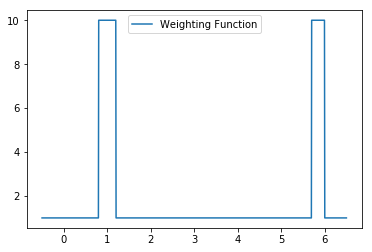

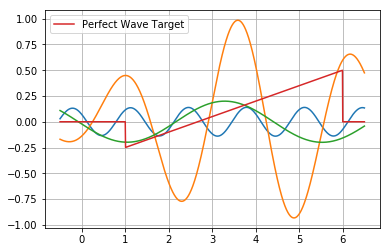

In [34]:
time = np.linspace(-0.5,6.5,1000)
pw=  []
w1 = []

def weight(time,lag,period,width1,width2,W):
    if time > lag and time < lag+width1:
        return W
    elif time > period + lag - width2 and time < lag+period+0.2:
        return W
    else:
        return 1

for t in time:
    pw.append(perfect_wave(0.25,5,t,1))
    w1.append(weight(t,0.8,5,0.4,0.1,10))
    
plt.plot(time,w1, label = "Weighting Function" )
plt.legend()
plt.figure()
    
pw = np.asarray(pw)
plt.plot(time,wave_packet(time,A = 0.14,dt = 20,omega = 4.71,lag = 4,b =0.0 ,phi = 1))
plt.plot(time,wave_packet(time,A = 1,dt = 4,omega = 2.36,lag = 4,b =0.0 ,phi = 1))
plt.plot(time,wave_packet(time,A = 0.20,dt = 40,omega = 1.4,lag = 4,b =0.0 ,phi = 1))
plt.plot(time,pw,label = "Perfect Wave Target")

plt.grid()
plt.legend()

We now need to re-write our cost function so that it takes the weighting function into account

In [37]:
def cost(X,time_domain,target):
    return np.sqrt(np.sum((np.absolute(target - pulse(time_domain,X))**2)*w1))


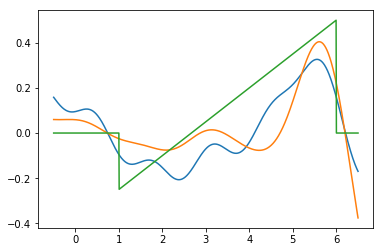

In [38]:
p1,p2 = find_initial_parents(500,pw,A1= 0.0,A2 = 0.14,dt1 = 20,dt2 = 20,dt3 = 4,dt4 = 4,dt5 = 40,dt6 = 40,
                             lag1 = 0, lag2 = 10, b1 = 0,b2 = 0.01,
             A3 = 0.0,A4 = 1.0,A5 = 0.0,A6 = 0.2,w1=4.71,w2=4.71,w3=2.365,w4=2.36,w5 = 1.88,w6 = 0.942)
plt.plot(time,pulse(time,p1))
plt.plot(time,pulse(time,p2))
plt.plot(time,pw)
#plt.savefig("initial_best_parents.png")

In [39]:
gen = 0

6.52808022438116
5.4522509274449815
5.25277835592994
5.10555407277595
4.997664648962838
4.874094425840229
4.808912367673871
4.707671712500223
4.6554897356987786
4.583885032554989
4.521128941651177
4.491333648074892
4.4520164816560435
4.440963385589008
4.4442542879946
4.436247927244178
4.426304555831315
4.423636662234817
4.419034814610464
4.418104033645618


array([[5.90602285e-02, 2.00004600e+01, 4.71000000e+00, 6.83689524e+00,
        6.83088391e-03, 3.62916650e+00],
       [6.06541232e-01, 4.00049504e+00, 2.36468958e+00, 8.01396782e+00,
        1.12700776e-02, 5.47890803e+00],
       [2.40066009e-01, 3.99985519e+01, 1.17921052e+00, 8.12809223e+00,
        8.75075310e-03, 3.97563589e+00]])

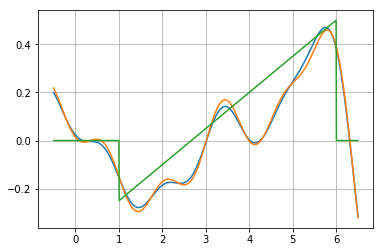

In [40]:
gen_N = 20
step_param = np.array([[0.01,0.001,0.0,0.1,0.001,0.01],  #pulse 1
                      [0.01,0.001,0.0,0.1,0.001,0.01],   #pulse 2
                      [0.01,0.001,0.001,0.1,0.001,0.01]]) #pulse 3
for i in range(gen_N):
    p1,p2 = new_gen(N = 200,parent1 = p1,parent2 = p2,target = pw,step = step_param*2, prob_of_mut= 0.0)
    print(cost(p1,time,pw))
plt.plot(time,pulse(time,p1))
plt.plot(time,pulse(time,p2))
plt.plot(time,pw)
plt.grid()
gen += gen_N
#plt.savefig("pulse_6_weighted\\gen_"+str(gen)+".png")
p1

[2.40066009e-01 3.99985519e+01 1.17921052e+00 8.12809223e+00
 8.75075310e-03 3.97563589e+00]
1
Amplitude: 0.05906022849606539 Arb. Units
Duration: 20.000460009160715 fs 
Wavelength 400.202885807617 nm
Lag 6.836895238012427 fs
Chirp param. 0.0068308839145912875 fs-2
Phase 3.629166502697036 rads
2
Amplitude: 0.6065412323175764 Arb. Units
Duration: 4.000495036072586 fs 
Wavelength 797.1260185872251 nm
Lag 8.01396781518647 fs
Chirp param. 0.011270077649453281 fs-2
Phase 5.478908034383588 rads
3
Amplitude: 0.24006600946885467 Arb. Units
Duration: 39.99855190768407 fs 
Wavelength 1598.4894616613838 nm
Lag 8.128092232098952 fs
Chirp param. 0.008750753101393564 fs-2
Phase 3.9756358913003322 rads


C:\Users\George\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-3, 10)

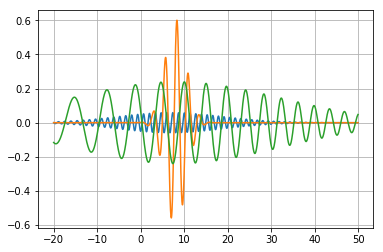

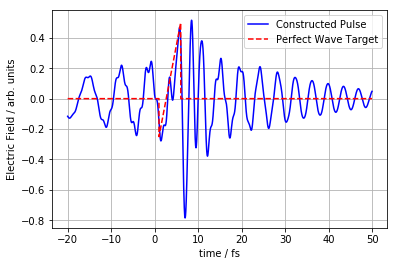

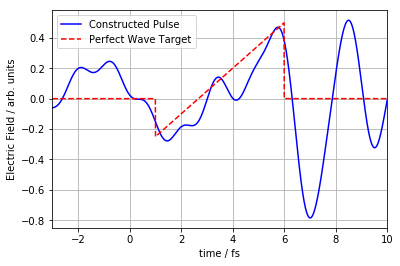

In [41]:
r1 = np.copy(p1)

time1 = np.linspace(-20,50,10000)
plt.plot(time1,wave_packet(time1,*r1[0]))
plt.plot(time1,wave_packet(time1,*r1[1]))
plt.plot(time1,wave_packet(time1,*r1[2]))
plt.grid()
print(r1[2])

this_pw = []
for t in time1:
    this_pw.append(perfect_wave(0.25,5,t,1))
    


plt.figure()
plt.plot(time1,wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]),
         color = "Blue",label = "Constructed Pulse")
plt.plot(time1,this_pw,'--', color = "red",label = "Perfect Wave Target")#parameters 0.25,15,t,3 
plt.grid()
plt.legend()
plt.xlabel("time / fs")
plt.ylabel("Electric Field / arb. units")

c = 0
for p in r1:
    c += 1
    print(c)
    print("Amplitude: "+str(p[0]) + " Arb. Units")
    print("Duration: "+str(p[1]) + " fs ")
    print("Wavelength " + str(6*np.pi*100/p[2]) + " nm")
    print("Lag " + str(p[3]) + " fs")
    print("Chirp param. " + str(p[4]) + " fs-2")
    print("Phase " + str(p[5]) + " rads")
    
    
    
plt.figure()
plt.plot(time1,wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]),
         color = "Blue",label = "Constructed Pulse")
plt.plot(time1,this_pw,'--', color = "red",label = "Perfect Wave Target")#parameters 0.25,15,t,3 
plt.grid()
plt.legend()
plt.xlabel("time / fs")
plt.ylabel("Electric Field / arb. units")
plt.xlim([-3,10])

As before, we save some good solutions below:

In [114]:
#saved solutions:
sol1 = np.array([[ 8.10946129e-02,  2.00004676e+01,  4.71000000e+00,
         3.85970812e+00, -2.20216900e-02,  2.73814991e+00],
       [ 1.41439875e+00,  3.99392426e+00,  2.36159698e+00,
         9.34725442e+00,  1.44975085e-01,  9.61046215e-01],
       [ 1.43671191e-01,  4.00040979e+01,  1.15194203e+00,
         6.41030002e+00,  6.09050023e-02,  1.92944387e+00]])

sol2 = np.array([[ 6.38587426e-02,  2.00013054e+01,  4.71000000e+00,
         6.66202240e+00, -1.20963520e-02,  3.28472588e+00],
       [ 6.84862586e-01,  4.00545044e+00,  2.36310258e+00,
         8.14248768e+00,  5.01011166e-02,  5.45918465e+00],
       [ 2.78911292e-01,  4.00008269e+01,  1.19833443e+00,
         7.37730844e+00,  9.50023190e-05,  3.43931866e+00]])

### Week 5

### Intensity Envelope Targets

As the last part of our project we applyied our algorythm to different targets. This time we produced pulsed to match a certain intensity rather than E-field profile.

First, we need to change the cost function as to evaluate intensity and change the pulse function so that we get E and not E.real as we did before:
(Above we needed to compare the real part of E to the perfect wave E-field but now we need both E.real and E.imag to get the correct intensity)

In [78]:
def cost(X,time_domain,target):                
    return np.sqrt(np.sum((np.absolute(target) - np.absolute(pulse(time_domain,X))**2)**2))

def pulse(time,X):
    '''
    X is a nested list that contained the parameters of each Gaussian wavepackets
    E.g. X = [params1,params2,params3] where paramsi = [dti,omegai,lagi,bi,phii]
    '''
    E = 0
    I = 0
    Phase = 0
    for params in X:
        E += wave_packet(time,A = params[0],dt = params[1], omega = params[2],lag = params[3], b = params[4], 
                         phi = params[5])
        
    return E

For all cases below we show our own results but the user is free to run the code again to 

#### Target 1: Intensity Spike

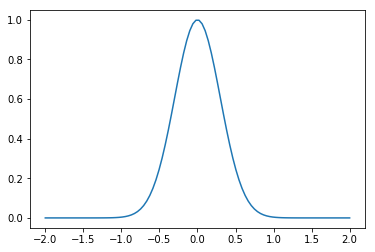

In [79]:
def spike(A,t,dt):  
    return A*np.exp(-(t*t)*2*np.log(2)/(dt*dt))

time = np.linspace(-2,2,100)
sp = spike(1,time,0.5)
plt.plot(time,sp)


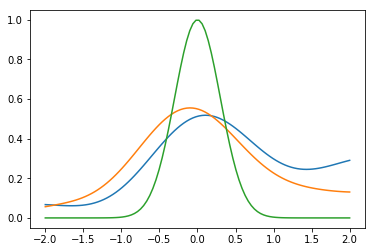

In [80]:
p1,p2 = find_initial_parents(500,sp,A1= 0.0,A2 = 0.14,dt1 = 20,dt2 = 20,dt3 = 4,dt4 = 4,dt5 = 40,dt6 = 40,
                             lag1 = -1, lag2 = 1, b1 = 0,b2 = 0.01,
             A3 = 0.0,A4 = 1.0,A5 = 0.0,A6 = 0.2,w1=4.71,w2=4.71,w3=2.365,w4=2.36,w5 = 1.88,w6 = 0.942)
plt.plot(time,np.absolute(pulse(time,p1))**2)
plt.plot(time,np.absolute(pulse(time,p2))**2)
plt.plot(time,sp)
#plt.savefig("initial_best_parents.png")

In [81]:
gen = 0

1.245955764959311
1.2399108290512906
1.2321051485892456
1.2314103617931131
1.2291536942015888
1.2267134783879456
1.2259454256196167
1.2250885922381558
1.2239727142615426
1.2291473924429106


C:\Users\George\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([[ 2.97620223e-01,  1.99994042e+01,  4.71000000e+00,
        -5.11957678e-01,  7.63473069e-03,  4.90024879e+00],
       [ 3.81354752e-01,  4.00006648e+00,  2.36421015e+00,
         4.94356536e-01,  8.10287435e-04,  2.27877658e+00],
       [ 1.91839202e-01,  4.00017277e+01,  9.87403943e-01,
         5.55900803e-01,  3.17141413e-03,  1.43407497e+00]])

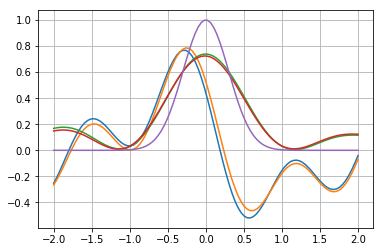

In [83]:
gen_N = 10
step_param = np.array([[0.01,0.001,0.0,0.1,0.001,0.01],  #pulse 1
                      [0.01,0.001,0.0,0.1,0.001,0.01],   #pulse 2
                      [0.01,0.001,0.001,0.1,0.001,0.01]]) #pulse 3
for i in range(gen_N):
    p1,p2 = new_gen(N = 200,parent1 = p1,parent2 = p2,target = sp,step = step_param*2, prob_of_mut= 0.0)
    print(cost(p1,time,sp))
plt.plot(time,pulse(time,p1))
plt.plot(time,pulse(time,p2))
plt.plot(time,np.absolute(pulse(time,p1))**2)
plt.plot(time,np.absolute(pulse(time,p2))**2)
plt.plot(time,sp)
plt.grid()
gen += gen_N
#plt.savefig("pulse_6_weighted\\gen_"+str(gen)+".png")
p1

[1.91839202e-01 4.00017277e+01 9.87403943e-01 5.55900803e-01
 3.17141413e-03 1.43407497e+00]
1
Amplitude: 0.29762022260759907 Arb. Units
Duration: 19.99940418212704 fs 
Wavelength 400.2028858076169 nm
Lag -0.5119576779104904 fs
Chirp param. 0.007634730692177801 fs-2
Phase 4.900248791134294 rads
2
Amplitude: 0.38135475185150436 Arb. Units
Duration: 4.000066475904567 fs 
Wavelength 797.2876644778729 nm
Lag 0.4943565358336071 fs
Chirp param. 0.0008102874353983218 fs-2
Phase 2.2787765807662117 rads
3
Amplitude: 0.19183920237834617 Arb. Units
Duration: 40.00172774254849 fs 
Wavelength 1909.0014834178435 nm
Lag 0.5559008034853784 fs
Chirp param. 0.0031714141278759694 fs-2
Phase 1.434074971339044 rads


C:\Users\George\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-5, 5)

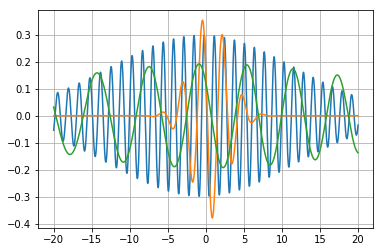

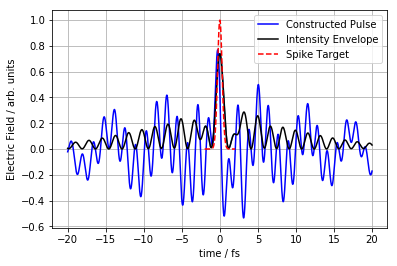

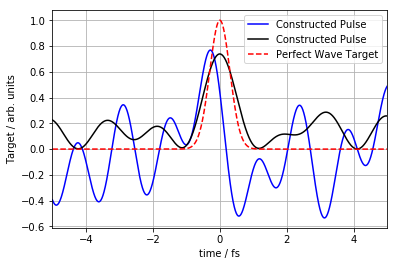

In [84]:
r1 = np.copy(p1)

time1 = np.linspace(-20,20,10000)
plt.plot(time1,wave_packet(time1,*r1[0]))
plt.plot(time1,wave_packet(time1,*r1[1]))
plt.plot(time1,wave_packet(time1,*r1[2]))
plt.grid()
print(r1[2])

this_pw = []
for t in time1:
    this_pw.append(perfect_wave(0.25,5,t,1))
    


plt.figure()
plt.plot(time,np.absolute(pulse(time,p1))**2)
plt.plot(time1,wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]),
         color = "Blue",label = "Constructed Pulse")
plt.plot(time1,np.absolute(wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]))**2,
         label = "Intensity Envelope",color = "Black")
plt.plot(time,sp,'--', color = "red",label = "Spike Target")#parameters 0.25,15,t,3 
plt.grid()
plt.legend()
plt.xlabel("time / fs")
plt.ylabel("Electric Field / arb. units")

c = 0
for p in r1:
    c += 1
    print(c)
    print("Amplitude: "+str(p[0]) + " Arb. Units")
    print("Duration: "+str(p[1]) + " fs ")
    print("Wavelength " + str(6*np.pi*100/p[2]) + " nm")
    print("Lag " + str(p[3]) + " fs")
    print("Chirp param. " + str(p[4]) + " fs-2")
    print("Phase " + str(p[5]) + " rads")
    
    
    
plt.figure()
plt.plot(time1,wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]),
         color = "Blue",label = "Constructed Pulse")
plt.plot(time1,np.absolute(wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]))**2,
         color = "Black",label = "Constructed Pulse")
plt.plot(time1,spike(1,time1,0.5),'--', color = "red",label = "Perfect Wave Target")#parameters 0.25,15,t,3 
plt.grid()
plt.legend()
plt.xlabel("time / fs")
plt.ylabel("Target / arb. units")
plt.xlim([-5,5])

#### Target 2: Flat top

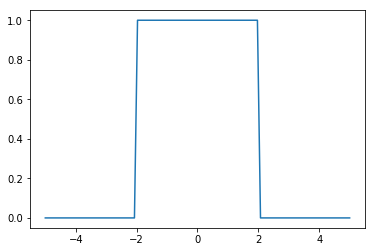

In [118]:
def flat_top(time,A,width):
    r1 = A*(time > -width/2)
    r2 = A*(time < width/2)
    return (r1 + r2) - A

time = np.linspace(-5,5,100)
ft = flat_top(time,1,4)
plt.plot(time,ft)

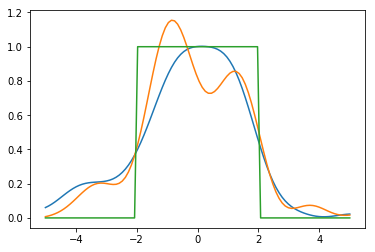

In [119]:
p1,p2 = find_initial_parents(500,ft,A1= 0.0,A2 = 0.14,dt1 = 20,dt2 = 20,dt3 = 4,dt4 = 4,dt5 = 40,dt6 = 40,
                             lag1 = -1, lag2 = 1, b1 = 0,b2 = 0.01,
             A3 = 0.0,A4 = 1.0,A5 = 0.0,A6 = 0.2,w1=4.71,w2=4.71,w3=2.365,w4=2.36,w5 = 1.88,w6 = 0.942)
plt.plot(time,np.absolute(pulse(time,p1))**2)
plt.plot(time,np.absolute(pulse(time,p2))**2)
plt.plot(time,ft)
#plt.savefig("initial_best_parents.png")

1.8229640922702695
1.6898461337120776
1.6615878712242507
1.644341862720592
1.63555590148585
1.6303922811672704
1.6253460855487936
1.6227826989541574
1.6197433871762088
1.6186558593858202


C:\Users\George\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([[ 1.33237208e-01,  2.00001131e+01,  4.71000000e+00,
         8.03661404e-02,  6.31065828e-03,  1.81201129e+00],
       [ 9.52027319e-01,  4.00086675e+00,  2.36214212e+00,
        -2.01969349e-01,  9.06495406e-03,  4.03553657e+00],
       [ 1.35479896e-01,  3.99999832e+01,  1.56449856e+00,
         3.69899005e-01,  2.50652684e-03,  5.47779574e+00]])

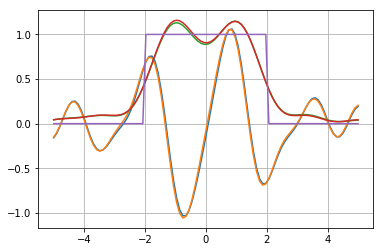

In [120]:
gen_N = 10
step_param = np.array([[0.01,0.001,0.0,0.1,0.001,0.01],  #pulse 1
                      [0.01,0.001,0.0,0.1,0.001,0.01],   #pulse 2
                      [0.01,0.001,0.001,0.1,0.001,0.01]]) #pulse 3
for i in range(gen_N):
    p1,p2 = new_gen(N = 200,parent1 = p1,parent2 = p2,target = ft,step = step_param*1, prob_of_mut= 0.0)
    print(cost(p1,time,ft))
plt.plot(time,pulse(time,p1))
plt.plot(time,pulse(time,p2))
plt.plot(time,np.absolute(pulse(time,p1))**2)
plt.plot(time,np.absolute(pulse(time,p2))**2)
plt.plot(time,ft)
plt.grid()
gen += gen_N
#plt.savefig("pulse_6_weighted\\gen_"+str(gen)+".png")
p1

[1.35479896e-01 3.99999832e+01 1.56449856e+00 3.69899005e-01
 2.50652684e-03 5.47779574e+00]
1
Amplitude: 0.1332372079951015 Arb. Units
Duration: 20.00011314048388 fs 
Wavelength 400.20288580761695 nm
Lag 0.08036614041142287 fs
Chirp param. 0.006310658282339607 fs-2
Phase 1.812011288124357 rads
2
Amplitude: 0.9520273194261134 Arb. Units
Duration: 4.0008667510358 fs 
Wavelength 797.9856822530709 nm
Lag -0.20196934927164434 fs
Chirp param. 0.009064954060922777 fs-2
Phase 4.03553657432659 rads
3
Amplitude: 0.1354798962452581 Arb. Units
Duration: 39.999983233523295 fs 
Wavelength 1204.830507936867 nm
Lag 0.36989900544402443 fs
Chirp param. 0.0025065268445084925 fs-2
Phase 5.4777957421898105 rads


C:\Users\George\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-5, 5)

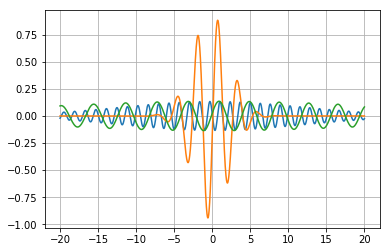

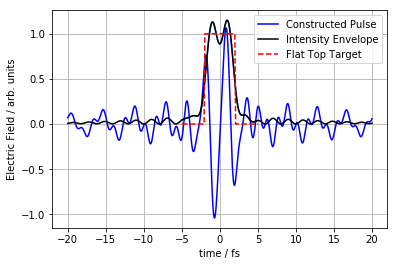

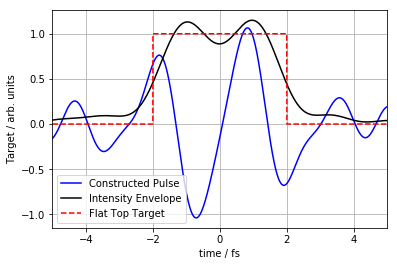

In [124]:
r1 = np.copy(p1)

time1 = np.linspace(-20,20,10000)
plt.plot(time1,wave_packet(time1,*r1[0]))
plt.plot(time1,wave_packet(time1,*r1[1]))
plt.plot(time1,wave_packet(time1,*r1[2]))
plt.grid()
print(r1[2])

this_pw = []
for t in time1:
    this_pw.append(perfect_wave(0.25,5,t,1))
    


plt.figure()
plt.plot(time,np.absolute(pulse(time,p1))**2)
plt.plot(time1,wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]),
         color = "Blue",label = "Constructed Pulse")
plt.plot(time1,np.absolute(wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]))**2,
         label = "Intensity Envelope",color = "Black")
plt.plot(time,ft,'--', color = "red",label = "Flat Top Target")#parameters 0.25,15,t,3 
plt.grid()
plt.legend()
plt.xlabel("time / fs")
plt.ylabel("Electric Field / arb. units")

c = 0
for p in r1:
    c += 1
    print(c)
    print("Amplitude: "+str(p[0]) + " Arb. Units")
    print("Duration: "+str(p[1]) + " fs ")
    print("Wavelength " + str(6*np.pi*100/p[2]) + " nm")
    print("Lag " + str(p[3]) + " fs")
    print("Chirp param. " + str(p[4]) + " fs-2")
    print("Phase " + str(p[5]) + " rads")
    
    
    
plt.figure()
plt.plot(time1,wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]),
         color = "Blue",label = "Constructed Pulse")
plt.plot(time1,np.absolute(wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]))**2,
         color = "Black",label = "Intensity Envelope")
plt.plot(time1,flat_top(time1,1,4),'--', color = "red",label = "Flat Top Target")#parameters 0.25,15,t,3 
plt.grid()
plt.legend()
plt.xlabel("time / fs")
plt.ylabel("Target / arb. units")
plt.xlim([-5,5])

#### Target 3: Double Pulse

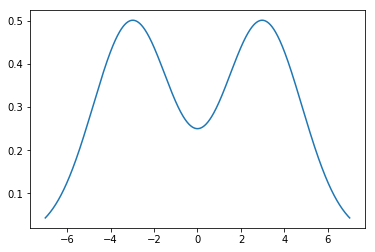

In [127]:
def spike(A,t,dt):  
    return A*np.exp(-(t*t)*2*np.log(2)/(dt*dt))

def d_pulse(A,t,dt,spacing):
    return spike(A,t+spacing/2,dt) + spike(A,t-spacing/2,dt)

time = np.linspace(-7,7,1000)
dp = d_pulse(0.5,time,3,6)

plt.plot(time,dp)

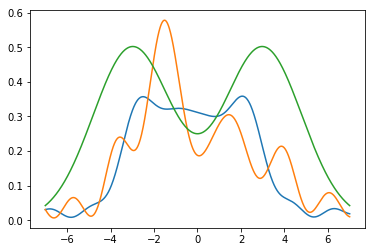

In [128]:
p1,p2 = find_initial_parents(500,dp,A1= 0.0,A2 = 0.14,dt1 = 20,dt2 = 20,dt3 = 4,dt4 = 4,dt5 = 40,dt6 = 40,
                             lag1 = -1, lag2 = 1, b1 = 0,b2 = 0.01,
             A3 = 0.0,A4 = 1.0,A5 = 0.0,A6 = 0.2,w1=4.71,w2=4.71,w3=2.365,w4=2.36,w5 = 1.88,w6 = 0.942)
plt.plot(time,np.absolute(pulse(time,p1))**2)
plt.plot(time,np.absolute(pulse(time,p2))**2)
plt.plot(time,dp)
#plt.savefig("initial_best_parents.png")

3.727863309162689
3.6336436039446096
3.536761228000701
3.4397540425556463
3.358645808220431
3.2607316932129975
3.184260750123899
3.0962255781928354
3.016719858644079
2.9545848916733153


C:\Users\George\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([[ 1.91035744e-02,  1.99991735e+01,  4.71000000e+00,
        -6.51337925e-02,  2.08497618e-03,  5.65350961e+00],
       [ 7.90838859e-01,  4.00250182e+00,  2.36364728e+00,
        -1.81624170e-01,  1.37978064e-03,  4.39033916e+00],
       [ 3.26306842e-01,  3.99985597e+01,  1.47363222e+00,
         4.14794302e-01,  3.32729298e-03,  2.18074071e+00]])

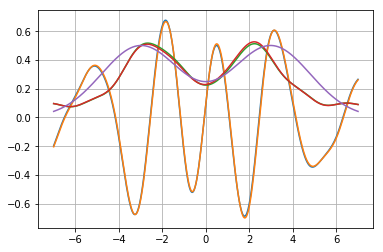

In [132]:
gen_N = 10
step_param = np.array([[0.01,0.001,0.0,0.1,0.001,0.01],  #pulse 1
                      [0.01,0.001,0.0,0.1,0.001,0.01],   #pulse 2
                      [0.01,0.001,0.001,0.1,0.001,0.01]]) #pulse 3
for i in range(gen_N):
    p1,p2 = new_gen(N = 200,parent1 = p1,parent2 = p2,target = dp,step = step_param*1, prob_of_mut= 0.0)
    print(cost(p1,time,dp))
plt.plot(time,pulse(time,p1))
plt.plot(time,pulse(time,p2))
plt.plot(time,np.absolute(pulse(time,p1))**2)
plt.plot(time,np.absolute(pulse(time,p2))**2)
plt.plot(time,dp)
plt.grid()
gen += gen_N
#plt.savefig("pulse_6_weighted\\gen_"+str(gen)+".png")
p1

[3.26306842e-01 3.99985597e+01 1.47363222e+00 4.14794302e-01
 3.32729298e-03 2.18074071e+00]
1
Amplitude: 0.0191035744 Arb. Units
Duration: 19.9991735 fs 
Wavelength 400.20288580761695 nm
Lag -0.0651337925 fs
Chirp param. 0.00208497618 fs-2
Phase 5.65350961 rads
2
Amplitude: 0.790838859 Arb. Units
Duration: 4.00250182 fs 
Wavelength 797.4775289458062 nm
Lag -0.18162417 fs
Chirp param. 0.00137978064 fs-2
Phase 4.39033916 rads
3
Amplitude: 0.326306842 Arb. Units
Duration: 39.9985597 fs 
Wavelength 1279.1221354768395 nm
Lag 0.414794302 fs
Chirp param. 0.00332729298 fs-2
Phase 2.18074071 rads


C:\Users\George\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-7, 7)

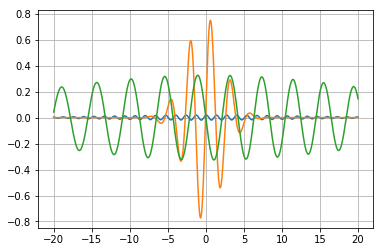

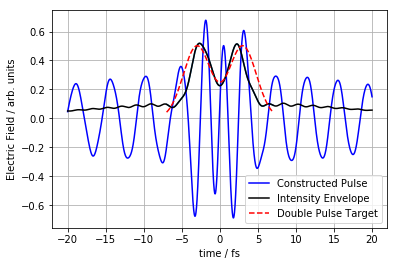

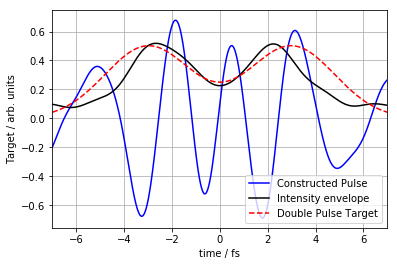

In [134]:
r1 = np.array([[ 1.91035744e-02,  1.99991735e+01,  4.71000000e+00,
        -6.51337925e-02,  2.08497618e-03,  5.65350961e+00],
       [ 7.90838859e-01,  4.00250182e+00,  2.36364728e+00,
        -1.81624170e-01,  1.37978064e-03,  4.39033916e+00],
       [ 3.26306842e-01,  3.99985597e+01,  1.47363222e+00,
         4.14794302e-01,  3.32729298e-03,  2.18074071e+00]])

time1 = np.linspace(-20,20,10000)
plt.plot(time1,wave_packet(time1,*r1[0]))
plt.plot(time1,wave_packet(time1,*r1[1]))
plt.plot(time1,wave_packet(time1,*r1[2]))
plt.grid()
print(r1[2])


plt.figure()
plt.plot(time,np.absolute(pulse(time,p1))**2)
plt.plot(time1,wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]),
         color = "Blue",label = "Constructed Pulse")
plt.plot(time1,np.absolute(wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]))**2,
         label = "Intensity Envelope",color = "Black")
plt.plot(time,dp,'--', color = "red",label = "Double Pulse Target")#parameters 0.25,15,t,3 
plt.grid()
plt.legend()
plt.xlabel("time / fs")
plt.ylabel("Electric Field / arb. units")

c = 0
for p in r1:
    c += 1
    print(c)
    print("Amplitude: "+str(p[0]) + " Arb. Units")
    print("Duration: "+str(p[1]) + " fs ")
    print("Wavelength " + str(6*np.pi*100/p[2]) + " nm")
    print("Lag " + str(p[3]) + " fs")
    print("Chirp param. " + str(p[4]) + " fs-2")
    print("Phase " + str(p[5]) + " rads")
    
    
    
plt.figure()
plt.plot(time1,wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]),
         color = "Blue",label = "Constructed Pulse")
plt.plot(time1,np.absolute(wave_packet(time1,*r1[0])+wave_packet(time1,*r1[1])+wave_packet(time1,*r1[2]))**2,
         color = "Black",label = "Intensity envelope")
plt.plot(time1,d_pulse(0.5,time1,3,6),'--', color = "red",label = "Double Pulse Target")#parameters 0.25,15,t,3 
plt.grid()
plt.legend()
plt.xlabel("time / fs")
plt.ylabel("Target / arb. units")
plt.xlim([-7,7])

This last pulse brings the project to an end.

### End Summary 

After the initial periferral tasks, we have seen how optmisation algorithms can be used to find the parameters that will return an aribtrary waveform. Although the basin-hoppin algorithm did produce some results we quickly abandoned it for the more accuracy, faster and more interesting Genetic Algorithm (GA). For both algorithms we developed a cost function which quantified the difference between the target waveform and a current solution. The task of this algorithms was to find the solution that minimizes this function thus our work is classified solving an optimisation (minimization) problem. Our cost function was fashioned according to [1].

We begun by writing our own algorithm - our own interpretation of what this concept should be. Having done that and producing promising results we compared our version with owns in the literature [2] and found them in agreement. Hence we continued with the GA. We made the algorithms task harder by fixing some parameters to the values that can be reproduced in the Department's lasers, thus making our result directly reproducible by experiment.

Lastly, uppon a request by our supervisor, we applied our algorithm to achieving different intensity profiles (while still limiting the values of the parameters withing physical bounds) and the algorithm had not trouble returning sattisfactory waveforms.


### References

[1] Christophe Dorrer and Ian A. (2002) Walmsley, "Accuracy criterion for ultrashort pulse characterization techniques: application to spectral phase interferometry for direct electric field reconstruction," J. Opt. Soc. Am. B 19, 1019-1029

[2] Eiben, A & Smith, Jim. (2003). Introduction To Evolutionary Computing. 10.1007/978-3-662-05094-1. 